In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil import parser
import math
import scipy.signal as ss
from apexpy import Apex
import igrf
from pysolar.solar import *
import scipy.io as io
from scipy import interpolate
import json

In [2]:
on2_lt=np.load('on2_rebin_lt.npy', allow_pickle=True)
on2_lon=np.load('on2_rebin_lon.npy', allow_pickle=True)

In [3]:
on2_lt.shape

(180, 120)

In [13]:
l=on2_lt[70,50]

In [14]:
x=[]
y=[]
for i in range(len(l)):
    x.append(l[i][0])
    y.append(l[i][1])

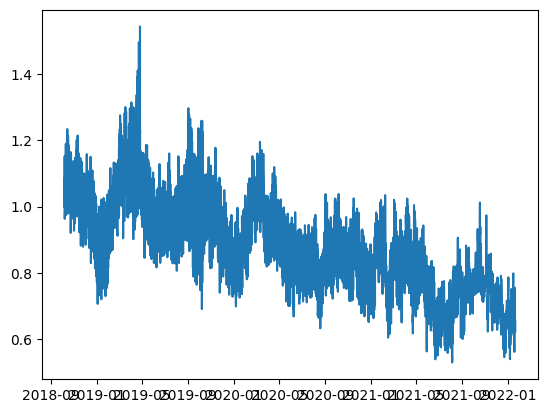

In [15]:
plt.plot(x,y)

In [16]:
dbin=np.array([20, 51, 79, 110, 140, 171, 201, 232, 263, 294, 324, 355])
month=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Process Kp 

In [17]:
f = open('/Users/wzihan/Dropbox (University of Michigan)/Academic/My Paper/gold_asymmetry/kp.json')
data=json.load(f)

In [18]:
kp=data['Kp']
kptime=data['datetime']
for i in range(len(kptime)):
    kptime[i]=datetime.datetime.strptime(kptime[i], '%Y-%m-%dT%H:%M:%SZ')
kptime=np.array(kptime)

In [19]:
kptime

array([datetime.datetime(2018, 1, 1, 0, 0),
       datetime.datetime(2018, 1, 1, 3, 0),
       datetime.datetime(2018, 1, 1, 6, 0), ...,
       datetime.datetime(2023, 3, 7, 15, 0),
       datetime.datetime(2023, 3, 7, 18, 0),
       datetime.datetime(2023, 3, 7, 21, 0)], dtype=object)

# Quiet time only (kp<3)

In [20]:
nlt=60
nlat=60
on2_lt_month=np.empty((12, nlt, nlat),dtype=object)
on2_lt_month_dt=np.empty((12, nlt, nlat),dtype=object)

for i in range(12):
    for j in range(nlat):
        for k in range(nlt):
            on2_lt_month[i,j,k]=[]
            on2_lt_month_dt[i,j,k]=[]

In [21]:
for j in range(nlat):
    for k in range(nlt):
        for c in range(3):
            for d in range(2):
                l=on2_lt[3*j+c,2*k+d]
                for t in range(len(l)):
                    dtime=l[t][0]
                    doy=dtime.timetuple().tm_yday 
                    ind=(365*(dtime.year-2018)+doy-1)*8
                    kt=kptime[ind:ind+56]
                    kpindex=np.argmin(abs(dtime-kt))
                    if dtime.year in [2019,2020,2021] and kp[ind+kpindex]<3:
                        on2_lt_month[np.argmin(abs(dbin-doy)),j,k].append(l[t][1])
                        on2_lt_month_dt[np.argmin(abs(dbin-doy)),j,k].append(l[t][0])

In [22]:
on2_lt_month_ave=np.empty((12, nlt, nlat))
on2_lt_month_std=np.empty((12, nlt, nlat))
on2_lt_month_cnt=np.empty((12, nlt, nlat))
for i in range(12):
    for j in range(nlat):
        for k in range(nlt):
            if len(on2_lt_month[i,j,k])<500:
                on2_lt_month_ave[i,j,k]=np.nan
                on2_lt_month_std[i,j,k]=np.nan
                on2_lt_month_cnt[i,j,k]=0
            else:
                on2_lt_month_ave[i,j,k]=np.mean(on2_lt_month[i,j,k])
                on2_lt_month_std[i,j,k]=np.std(on2_lt_month[i,j,k])
                on2_lt_month_cnt[i,j,k]=len(on2_lt_month[i,j,k])
            if j>22 and j<37:
                on2_lt_month_ave[i,j,k]=np.nan
                on2_lt_month_std[i,j,k]=np.nan
                on2_lt_month_cnt[i,j,k]=0

Text(0.5, 1.0, 'Counts')

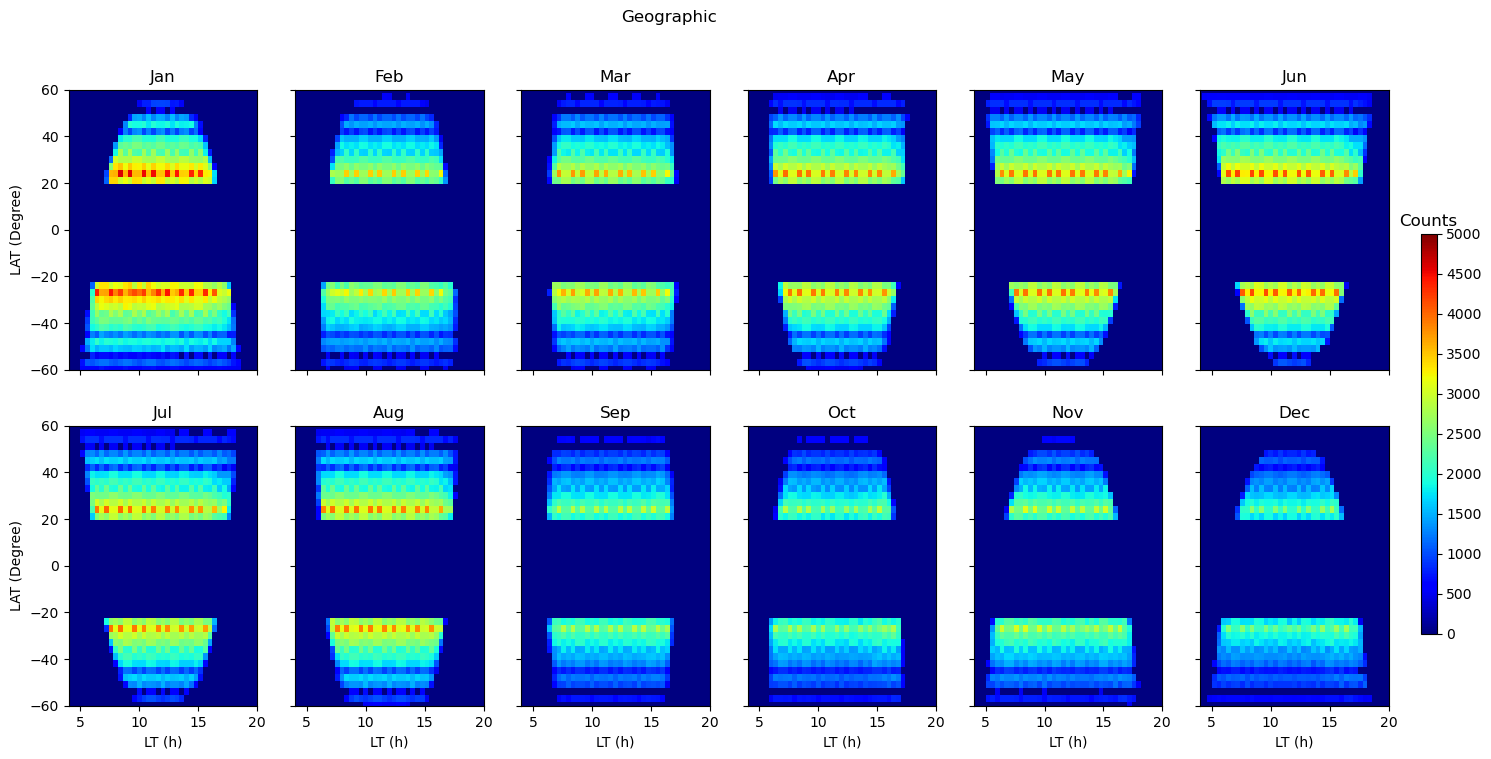

In [31]:
fig=plt.figure(figsize=(16,8))
axs = fig.subplots(2, 6, sharex='col', sharey='row')

x = np.arange(0, 24, 0.4)
y = np.arange(-90, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)
levels=np.arange(0,4000,40)

for i in range(12):
    cs= axs[i//6, i%6].pcolormesh(X,Y,np.transpose(on2_lt_month_cnt[i,:,:]), vmax=5000, cmap='jet')
    axs[i//6, i%6].set_ylim([-60,60])
    axs[i//6, i%6].set_xlim([4,20])
    axs[i//6, i%6].set_title(month[i])
    if i//6==1:
        axs[i//6, i%6].set_xlabel('LT (h)')
    if i% 6 ==0:
        axs[i//6, i%6].set_ylabel('LAT (Degree)')
#     # pyplot.savefig('/Users/wzihan/plot/gold/on2_diff_month_mlt_'+str(i+1))
# plt.colorbar(cs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.5])
cb=fig.colorbar(cs, cax=cbar_ax)
cb.set_ticks(np.linspace(0,5000,11))
fig.suptitle('Geographic')
cbar_ax.set_title('Counts')
# plt.savefig('2a.svg')

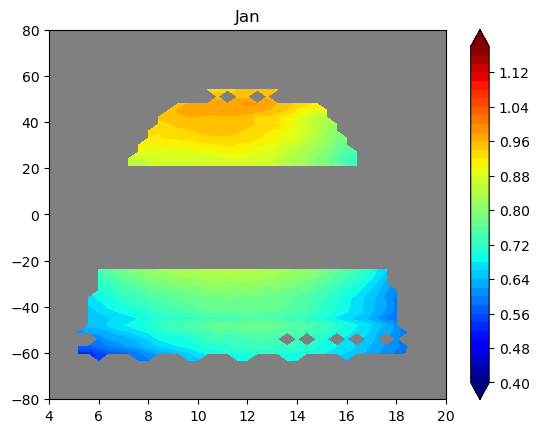

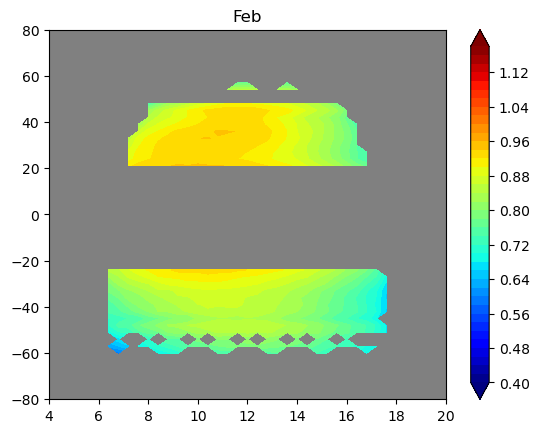

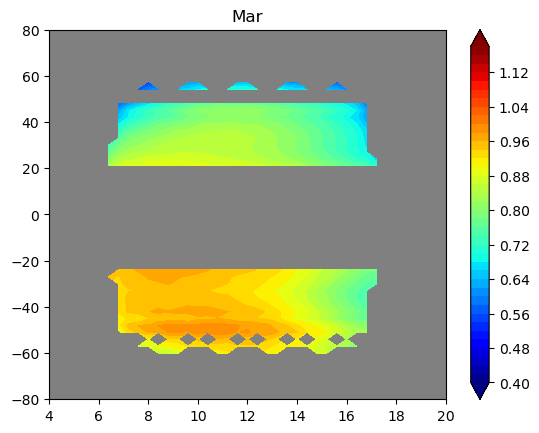

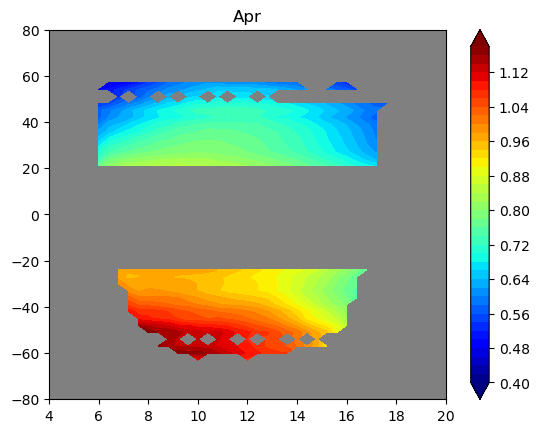

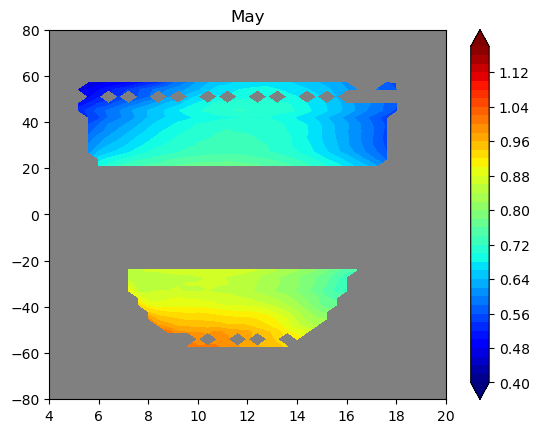

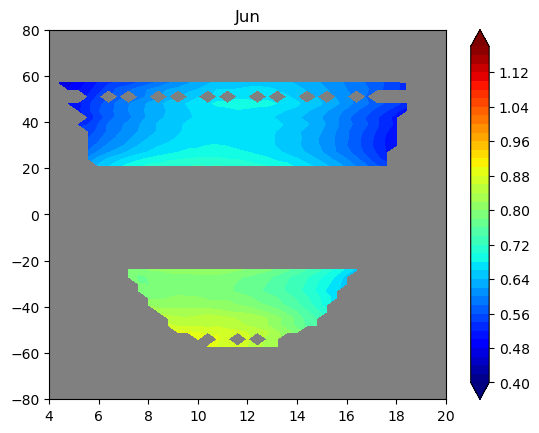

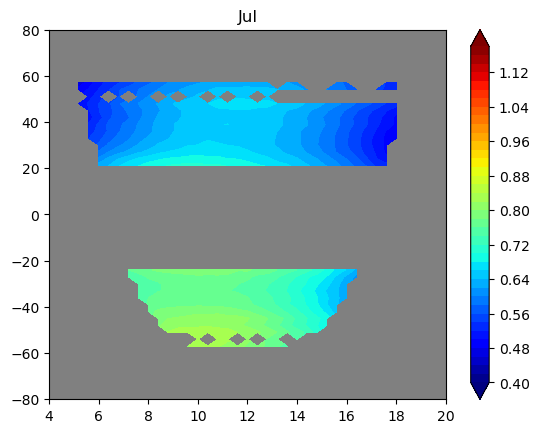

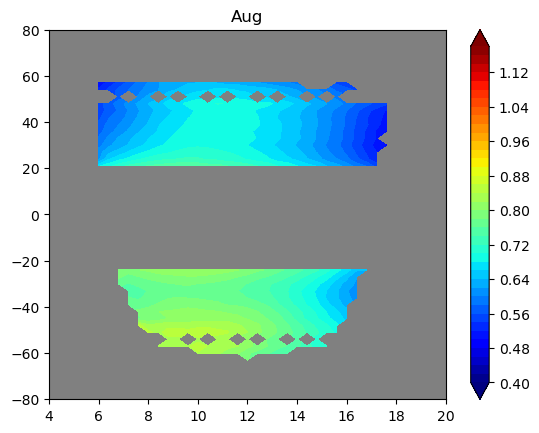

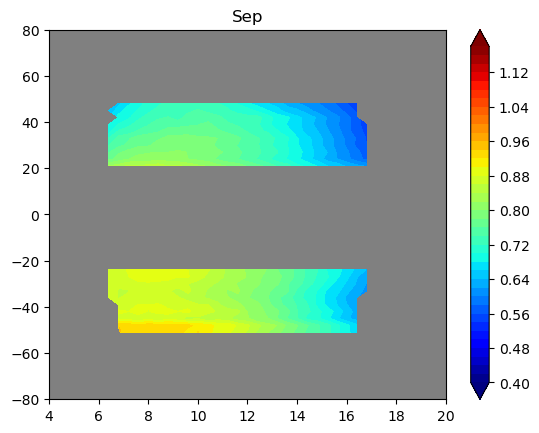

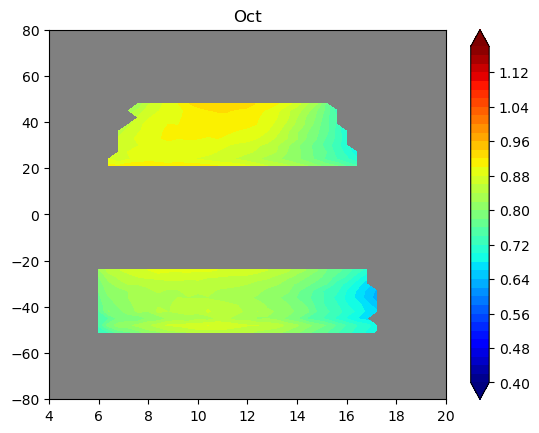

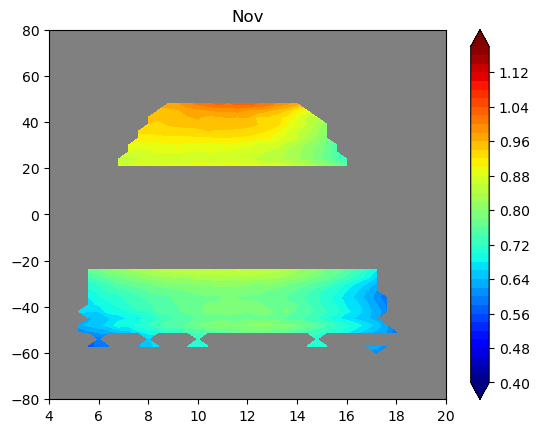

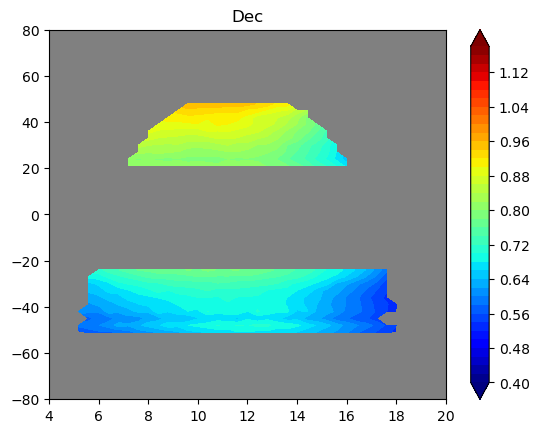

In [24]:
x = np.arange(0, 24, 0.4)
y = np.arange(-90, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)
levels=np.arange(0.4,1.2,0.02)
for i in range(12):
    fig, ax = plt.subplots()
    ax.set_facecolor("grey") 
    cs= ax.contourf(X,Y,np.transpose(on2_lt_month_ave[i,:,:]),levels=levels, cmap='jet', extend='both')
    cb=plt.colorbar(cs)
    plt.ylim([-80,80])
    plt.xlim([4,20])
    plt.title(month[i])
    # pyplot.savefig('/Users/wzihan/plot/gold/on2_month_mlt_'+str(i+1))

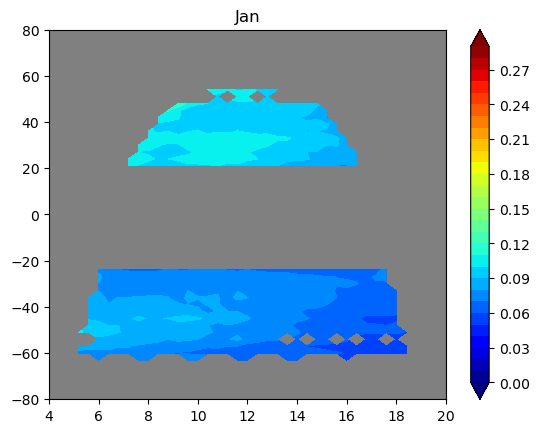

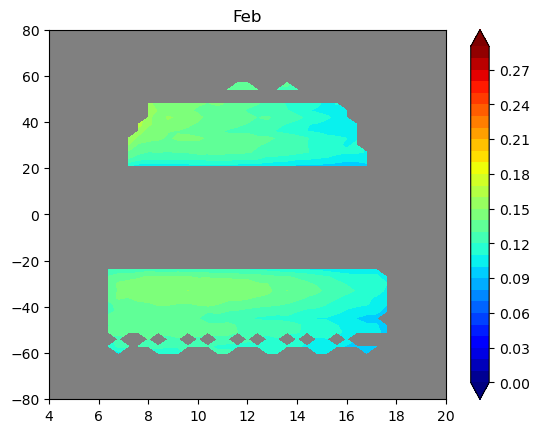

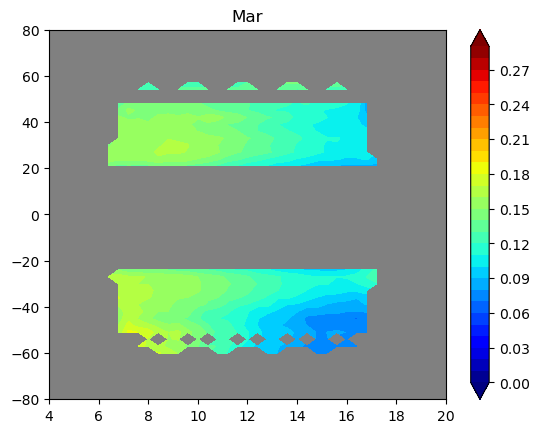

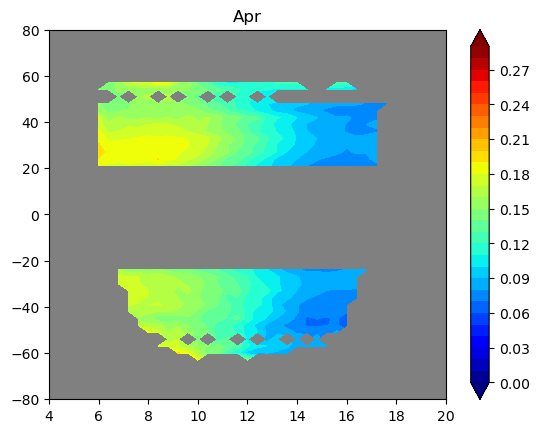

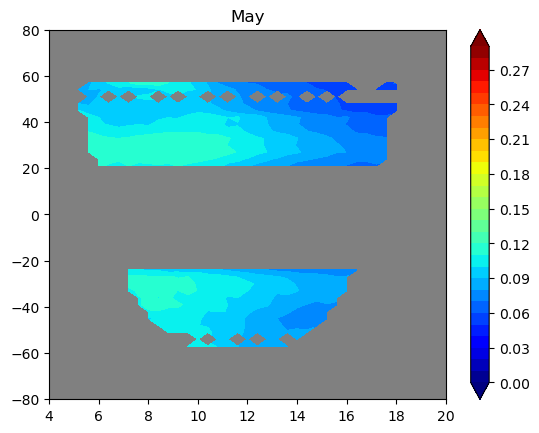

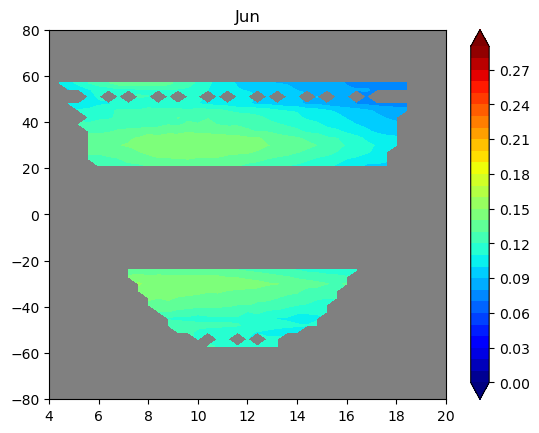

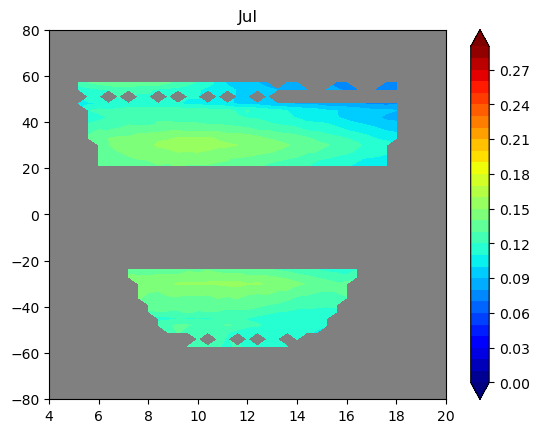

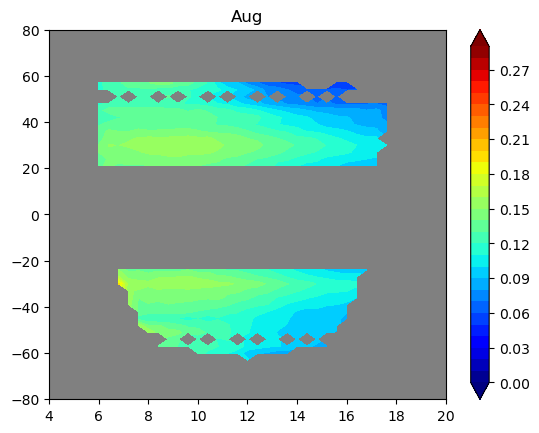

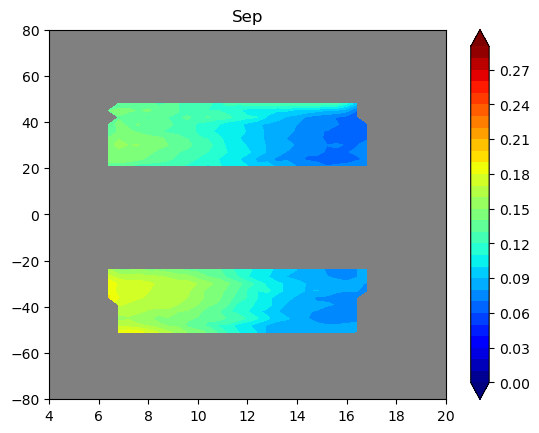

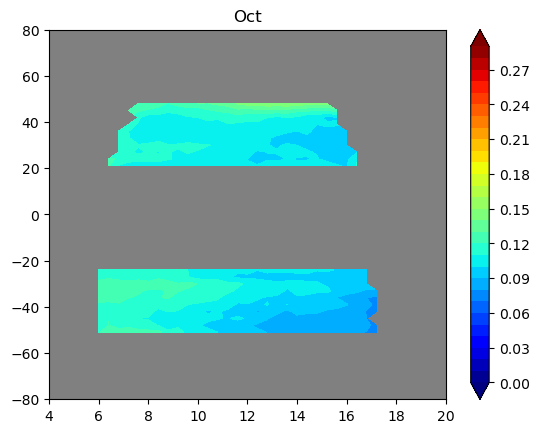

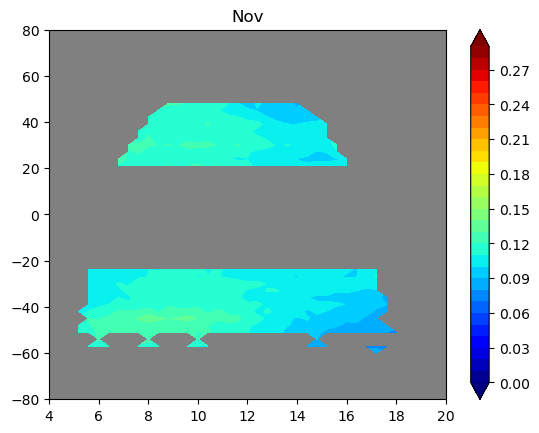

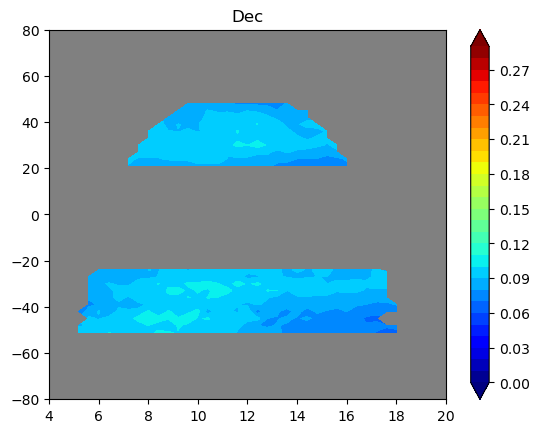

In [25]:
levels=np.arange(0,0.3,0.01)
for i in range(12):
    fig, ax = plt.subplots()
    ax.set_facecolor("grey") 
    cs= ax.contourf(X,Y,np.transpose(on2_lt_month_std[i,:,:]),levels=levels, cmap='jet', extend='both')
    cb=plt.colorbar(cs)
    plt.ylim([-80,80])
    plt.xlim([4,20])
    plt.title(month[i])
    # pyplot.savefig('/Users/wzihan/plot/gold/on2_month_mlt_'+str(i+1))

In [26]:
delta=np.zeros((12, nlat//2, nlt))

for i in range(12):
    for j in range(nlat//2):
        for k in range(nlt):
            s=on2_lt_month_ave[i,nlat-1-j,k]+on2_lt_month_ave[i,j,k]
            diff=on2_lt_month_ave[i,nlat-1-j,k]-on2_lt_month_ave[i,j,k]
            delta[i,nlat//2-1-j,k]=2*diff/s

In [27]:
x = np.arange(0, 24, 2/5.)
y = np.arange(0, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)

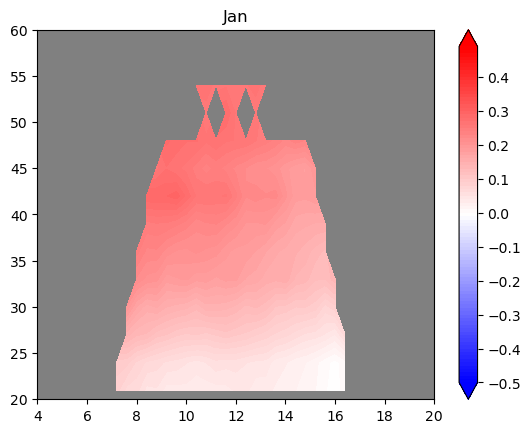

In [28]:
levels=np.arange(-0.5,0.5,0.01)
fig=plt.figure()
axs = fig.subplots(1, 1, sharex='col', sharey='row')

i=0
axs.set_facecolor("grey")  
cs= axs.contourf(X,Y,np.transpose(delta[i,:,:]),levels=levels, cmap='bwr', extend='both')
axs.set_ylim([20,60])
axs.set_xlim([4,20])
axs.set_title(month[i])
fig.colorbar(cs)

Text(0.5, 1.0, '$AI_{\\Sigma O/N_2}$')

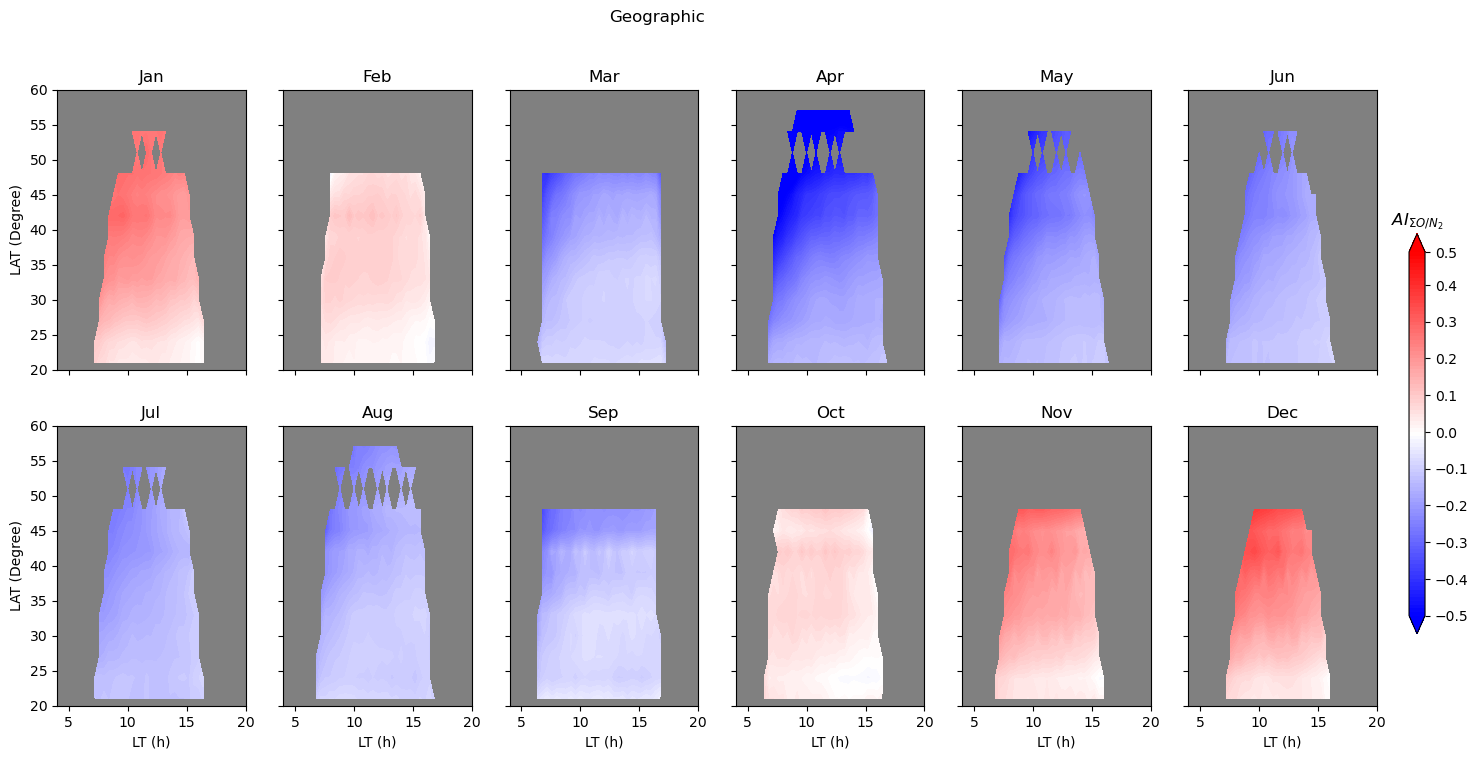

In [29]:
fig=plt.figure(figsize=(16,8))
axs = fig.subplots(2, 6, sharex='col', sharey='row')

for i in range(12):
    axs[i//6, i%6].set_facecolor("grey")  
    cs= axs[i//6, i%6].contourf(X,Y,np.transpose(delta[i,:,:]),levels=levels, cmap='bwr', extend='both')
    axs[i//6, i%6].set_ylim([20,60])
    axs[i//6, i%6].set_xlim([4,20])
    axs[i//6, i%6].set_title(month[i])
    if i//6==1:
        axs[i//6, i%6].set_xlabel('LT (h)')
    if i% 6 ==0:
        axs[i//6, i%6].set_ylabel('LAT (Degree)')
#     # pyplot.savefig('/Users/wzihan/plot/gold/on2_diff_month_mlt_'+str(i+1))
# plt.colorbar(cs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.5])
cb=fig.colorbar(cs, cax=cbar_ax)
cb.set_ticks(np.linspace(-0.5,0.5,11))
fig.suptitle('Geographic')
cbar_ax.set_title('$AI_{\Sigma O/N_2}$')
# plt.savefig('2a.svg')

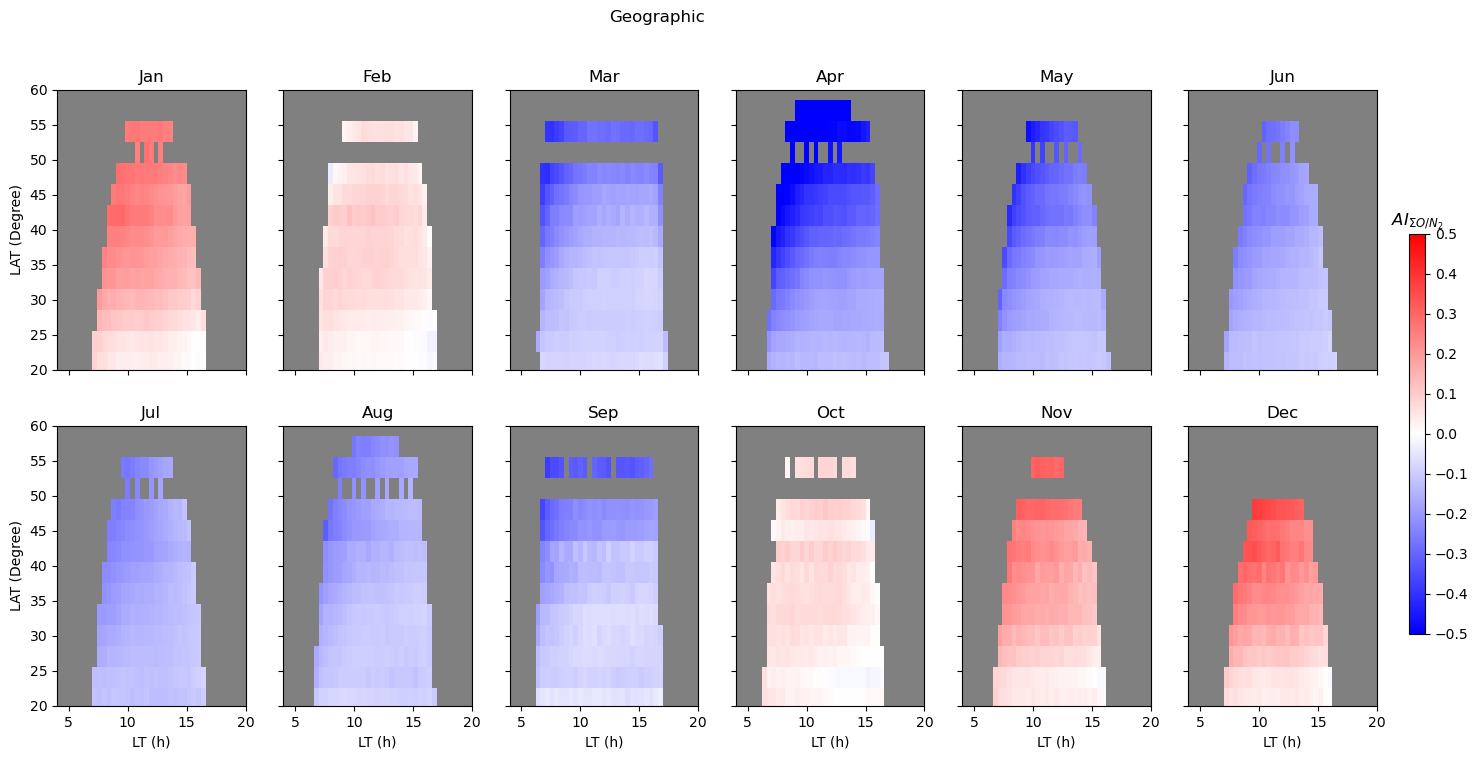

In [30]:
fig=plt.figure(figsize=(16,8))
axs = fig.subplots(2, 6, sharex='col', sharey='row')

for i in range(12):
    axs[i//6, i%6].set_facecolor("grey")  
    cs= axs[i//6, i%6].pcolormesh(X,Y,np.transpose(delta[i,:,:]), cmap='bwr', vmax=0.5, vmin=-0.5)
    axs[i//6, i%6].set_ylim([20,60])
    axs[i//6, i%6].set_xlim([4,20])
    axs[i//6, i%6].set_title(month[i])
    if i//6==1:
        axs[i//6, i%6].set_xlabel('LT (h)')
    if i% 6 ==0:
        axs[i//6, i%6].set_ylabel('LAT (Degree)')
#     # pyplot.savefig('/Users/wzihan/plot/gold/on2_diff_month_mlt_'+str(i+1))
# plt.colorbar(cs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.5])
cb=fig.colorbar(cs, cax=cbar_ax)
cb.set_ticks(np.linspace(-0.5,0.5,11))
fig.suptitle('Geographic')
cbar_ax.set_title('$AI_{\Sigma O/N_2}$')
plt.savefig('2a.svg')

# Quiet time only (kp<3) and Long<45W

In [11]:
nlt=60
nlat=60
on2_lt_month=np.empty((12, nlt, nlat),dtype=object)
on2_lt_month_dt=np.empty((12, nlt, nlat),dtype=object)

for i in range(12):
    for j in range(nlat):
        for k in range(nlt):
            on2_lt_month[i,j,k]=[]
            on2_lt_month_dt[i,j,k]=[]

In [13]:
for j in range(nlat):
    for k in range(nlt):
        for c in range(3):
            for d in range(2):
                l=on2_lt[3*j+c,2*k+d]
                for t in range(len(l)):
                    dtime=l[t][0]
                    doy=dtime.timetuple().tm_yday 
                    ind=(365*(dtime.year-2018)+doy-1)*8
                    kt=kptime[ind:ind+56]
                    kpindex=np.argmin(abs(dtime-kt))
                    lt=k*0.4
                    lon=(lt-dtime.hour-dtime.minute/60)*15
                    if lon>180: lon=lon-360
                    if lon<-180: lon=lon+360
                    if dtime.year in [2019,2020,2021] and kp[ind+kpindex]<3 and lon<-45:
                        on2_lt_month[np.argmin(abs(dbin-doy)),j,k].append(l[t][1])
                        on2_lt_month_dt[np.argmin(abs(dbin-doy)),j,k].append(l[t][0])

In [14]:
on2_lt_month_ave=np.empty((12, nlt, nlat))
on2_lt_month_std=np.empty((12, nlt, nlat))
on2_lt_month_cnt=np.empty((12, nlt, nlat))
for i in range(12):
    for j in range(nlat):
        for k in range(nlt):
            if len(on2_lt_month[i,j,k])==0:
                on2_lt_month_ave[i,j,k]=np.nan
                on2_lt_month_std[i,j,k]=np.nan
                on2_lt_month_cnt[i,j,k]=0
            else:
                on2_lt_month_ave[i,j,k]=np.mean(on2_lt_month[i,j,k])
                on2_lt_month_std[i,j,k]=np.std(on2_lt_month[i,j,k])
                on2_lt_month_cnt[i,j,k]=len(on2_lt_month[i,j,k])
            if j>22 and j<37:
                on2_lt_month_ave[i,j,k]=np.nan
                on2_lt_month_std[i,j,k]=np.nan
                on2_lt_month_cnt[i,j,k]=0

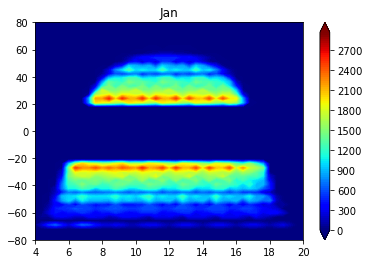

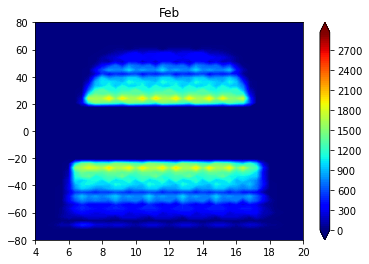

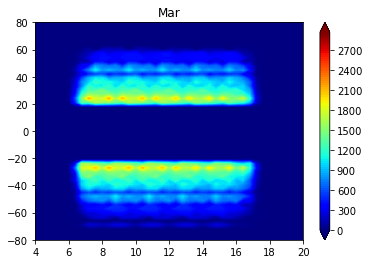

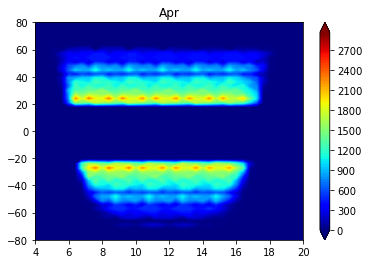

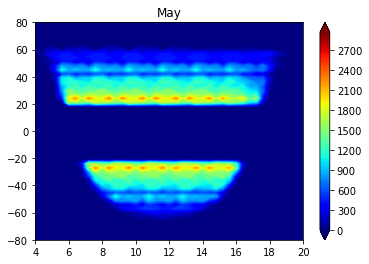

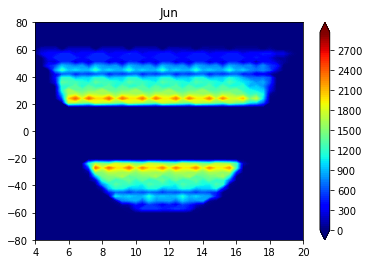

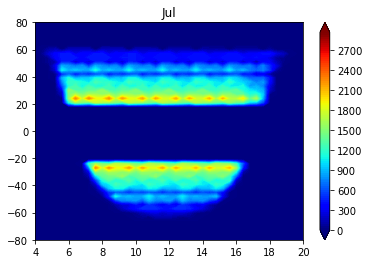

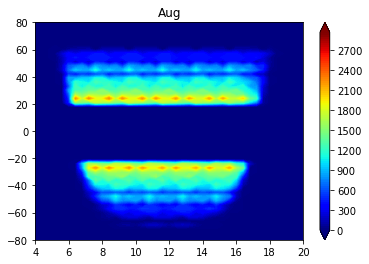

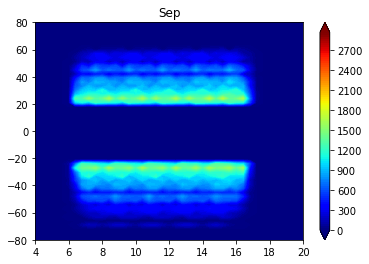

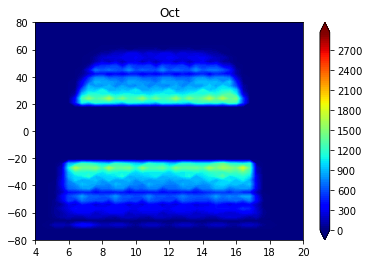

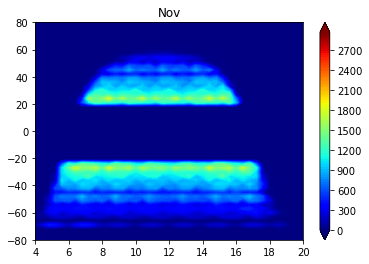

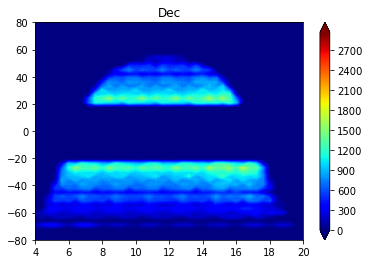

In [15]:
x = np.arange(0, 24, 0.4)
y = np.arange(-90, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)
levels=np.arange(0,3000,30)
for i in range(12):
    fig, ax = plt.subplots()
    cs= ax.contourf(X,Y,np.transpose(on2_lt_month_cnt[i,:,:]), levels=levels, cmap='jet', extend='both')
    cb=plt.colorbar(cs)
    plt.ylim([-80,80])
    plt.xlim([4,20])
    plt.title(month[i])
    # pyplot.savefig('/Users/wzihan/plot/gold/on2_month_mlt_'+str(i+1))

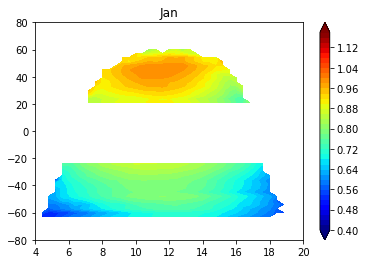

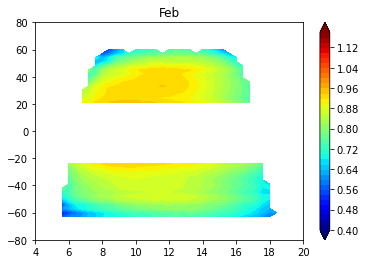

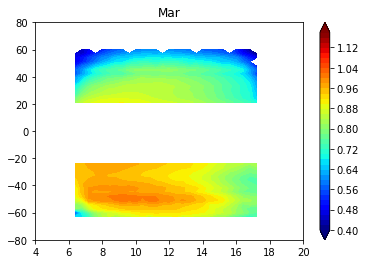

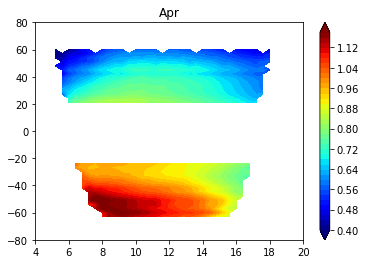

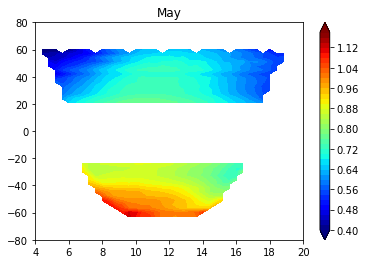

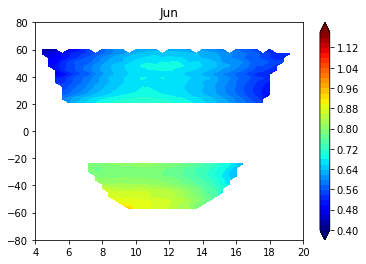

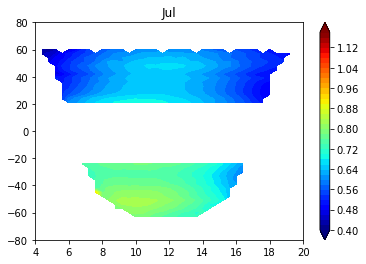

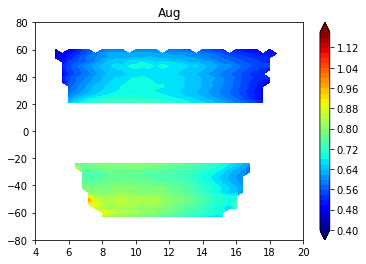

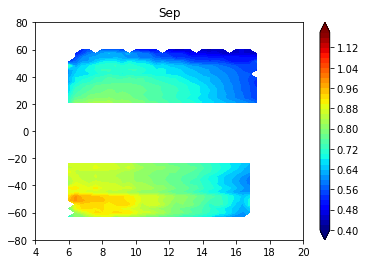

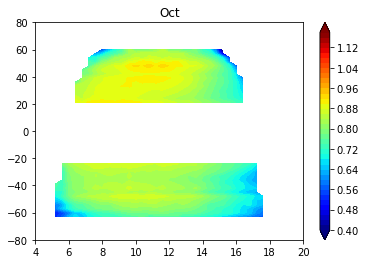

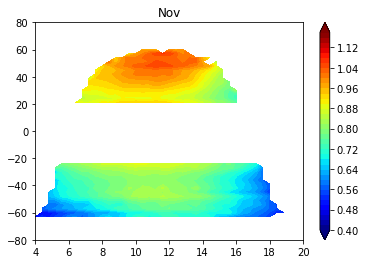

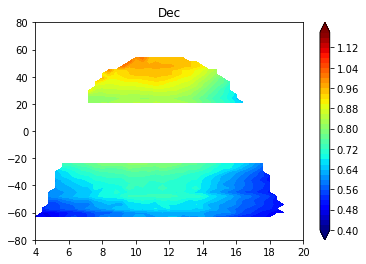

In [16]:
x = np.arange(0, 24, 0.4)
y = np.arange(-90, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)
levels=np.arange(0.4,1.2,0.02)
for i in range(12):
    fig, ax = plt.subplots()
    cs= ax.contourf(X,Y,np.transpose(on2_lt_month_ave[i,:,:]),levels=levels, cmap='jet', extend='both')
    cb=plt.colorbar(cs)
    plt.ylim([-80,80])
    plt.xlim([4,20])
    plt.title(month[i])
    # pyplot.savefig('/Users/wzihan/plot/gold/on2_month_mlt_'+str(i+1))

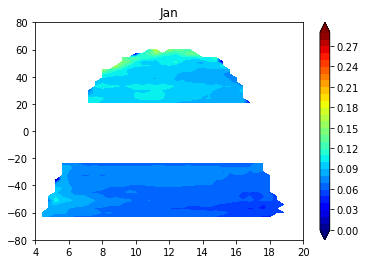

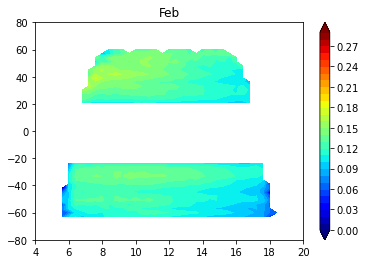

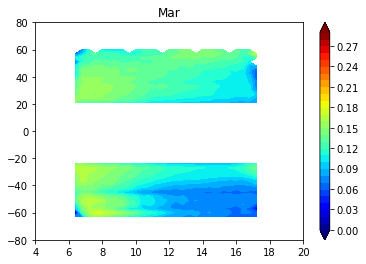

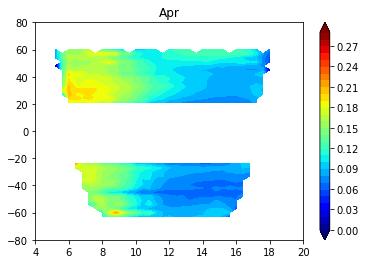

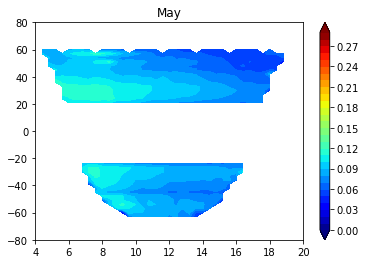

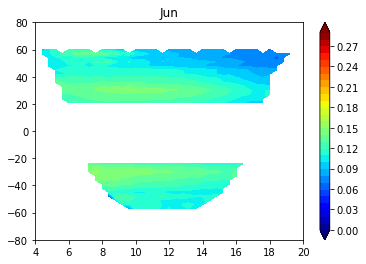

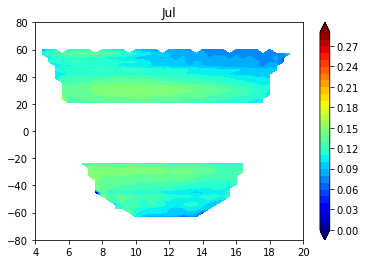

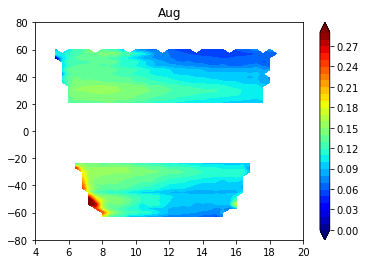

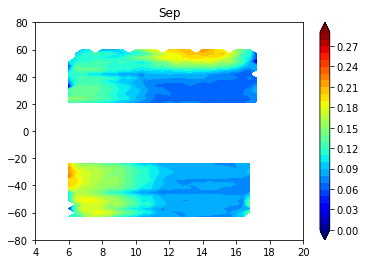

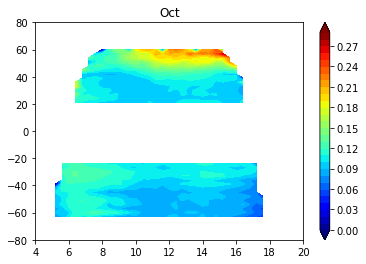

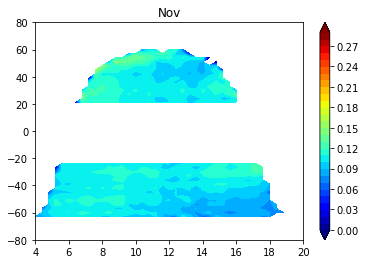

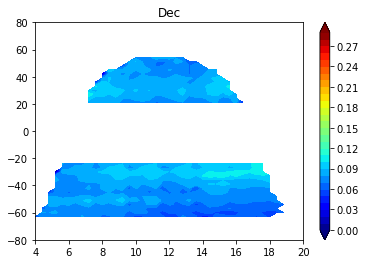

In [17]:
levels=np.arange(0,0.3,0.01)
for i in range(12):
    fig, ax = plt.subplots()
    cs= ax.contourf(X,Y,np.transpose(on2_lt_month_std[i,:,:]),levels=levels, cmap='jet', extend='both')
    cb=plt.colorbar(cs)
    plt.ylim([-80,80])
    plt.xlim([4,20])
    plt.title(month[i])
    # pyplot.savefig('/Users/wzihan/plot/gold/on2_month_mlt_'+str(i+1))

In [18]:
delta=np.zeros((12, nlat//2, nlt))

for i in range(12):
    for j in range(nlat//2):
        for k in range(nlt):
            s=on2_lt_month_ave[i,nlat-1-j,k]+on2_lt_month_ave[i,j,k]
            diff=on2_lt_month_ave[i,nlat-1-j,k]-on2_lt_month_ave[i,j,k]
            delta[i,nlat//2-1-j,k]=2*diff/s

In [19]:
x = np.arange(0, 24, 2/5.)
y = np.arange(0, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)

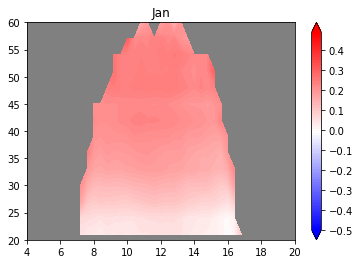

In [20]:
levels=np.arange(-0.5,0.5,0.01)
fig=plt.figure()
axs = fig.subplots(1, 1, sharex='col', sharey='row')

i=0
axs.set_facecolor("grey")  
cs= axs.contourf(X,Y,np.transpose(delta[i,:,:]),levels=levels, cmap='bwr', extend='both')
axs.set_ylim([20,60])
axs.set_xlim([4,20])
axs.set_title(month[i])
fig.colorbar(cs)

Text(0.5, 1.0, '$\\Delta$ $O/N_2$')

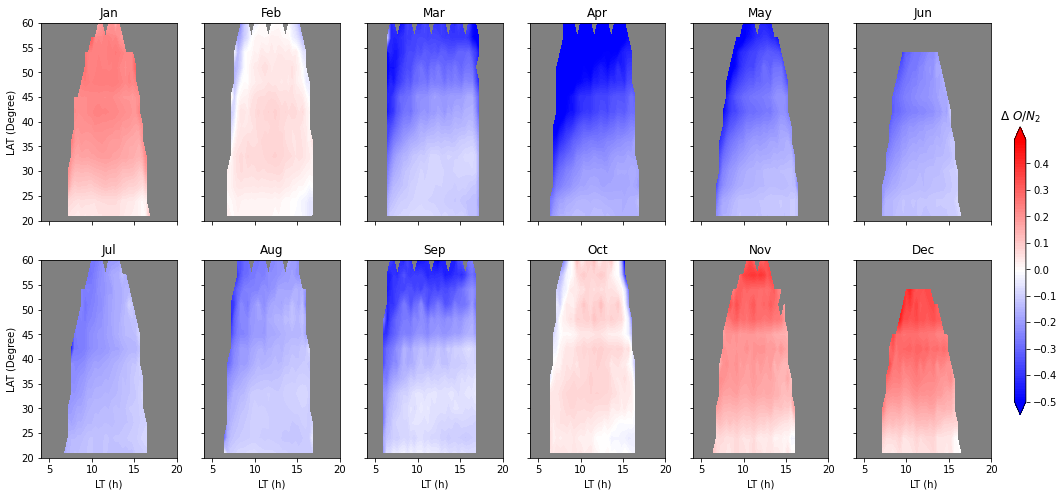

In [21]:
fig=plt.figure(figsize=(16,8))
axs = fig.subplots(2, 6, sharex='col', sharey='row')

for i in range(12):
    axs[i//6, i%6].set_facecolor("grey")  
    cs= axs[i//6, i%6].contourf(X,Y,np.transpose(delta[i,:,:]),levels=levels, cmap='bwr', extend='both')
    axs[i//6, i%6].set_ylim([20,60])
    axs[i//6, i%6].set_xlim([4,20])
    axs[i//6, i%6].set_title(month[i])
    if i//6==1:
        axs[i//6, i%6].set_xlabel('LT (h)')
    if i% 6 ==0:
        axs[i//6, i%6].set_ylabel('LAT (Degree)')
#     # pyplot.savefig('/Users/wzihan/plot/gold/on2_diff_month_mlt_'+str(i+1))
# plt.colorbar(cs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.5])
fig.colorbar(cs, cax=cbar_ax)
cbar_ax.set_title('$\Delta$ $O/N_2$')

# Quiet time only (kp<3) and Long>45W

In [23]:
nlt=60
nlat=60
on2_lt_month=np.empty((12, nlt, nlat),dtype=object)
on2_lt_month_dt=np.empty((12, nlt, nlat),dtype=object)

for i in range(12):
    for j in range(nlat):
        for k in range(nlt):
            on2_lt_month[i,j,k]=[]
            on2_lt_month_dt[i,j,k]=[]

In [24]:
for j in range(nlat):
    for k in range(nlt):
        for c in range(3):
            for d in range(2):
                l=on2_lt[3*j+c,2*k+d]
                for t in range(len(l)):
                    dtime=l[t][0]
                    doy=dtime.timetuple().tm_yday 
                    ind=(365*(dtime.year-2018)+doy-1)*8
                    kt=kptime[ind:ind+56]
                    kpindex=np.argmin(abs(dtime-kt))
                    lt=k*0.4
                    lon=(lt-dtime.hour-dtime.minute/60)*15
                    if lon>180: lon=lon-360
                    if lon<-180: lon=lon+360
                    if dtime.year in [2019,2020,2021] and kp[ind+kpindex]<3 and lon>-45:
                        on2_lt_month[np.argmin(abs(dbin-doy)),j,k].append(l[t][1])
                        on2_lt_month_dt[np.argmin(abs(dbin-doy)),j,k].append(l[t][0])

In [25]:
on2_lt_month_ave=np.empty((12, nlt, nlat))
on2_lt_month_std=np.empty((12, nlt, nlat))
on2_lt_month_cnt=np.empty((12, nlt, nlat))
for i in range(12):
    for j in range(nlat):
        for k in range(nlt):
            if len(on2_lt_month[i,j,k])==0:
                on2_lt_month_ave[i,j,k]=np.nan
                on2_lt_month_std[i,j,k]=np.nan
                on2_lt_month_cnt[i,j,k]=0
            else:
                on2_lt_month_ave[i,j,k]=np.mean(on2_lt_month[i,j,k])
                on2_lt_month_std[i,j,k]=np.std(on2_lt_month[i,j,k])
                on2_lt_month_cnt[i,j,k]=len(on2_lt_month[i,j,k])
            if j>22 and j<37:
                on2_lt_month_ave[i,j,k]=np.nan
                on2_lt_month_std[i,j,k]=np.nan
                on2_lt_month_cnt[i,j,k]=0

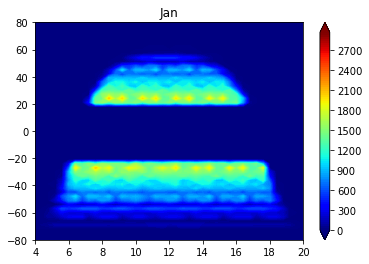

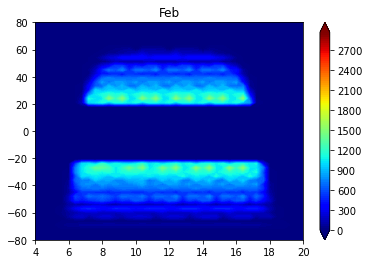

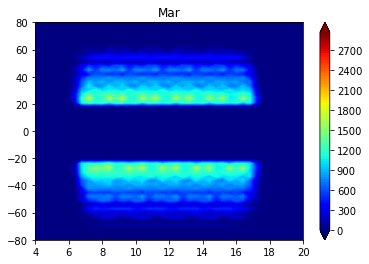

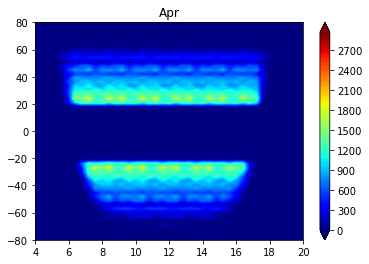

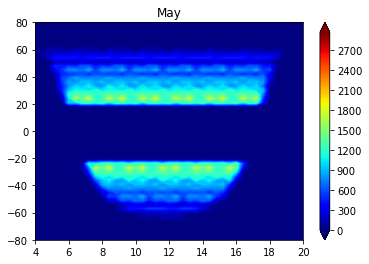

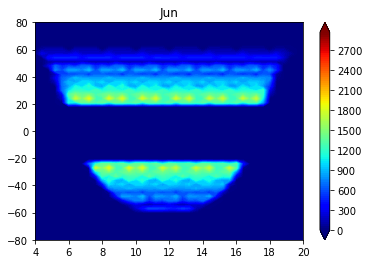

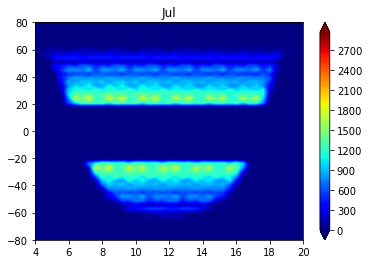

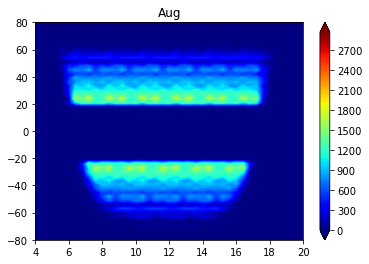

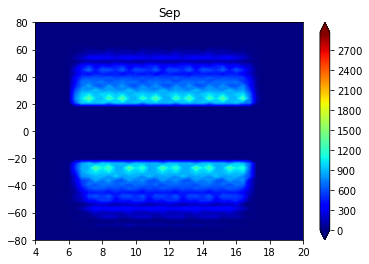

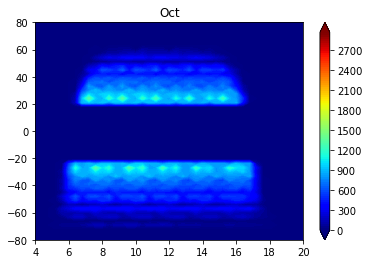

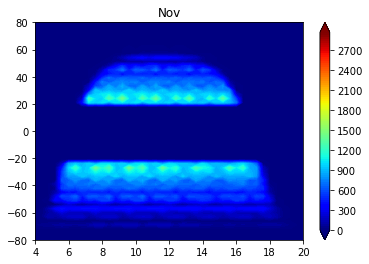

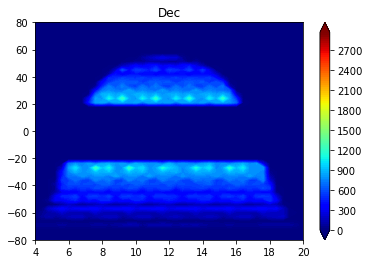

In [26]:
x = np.arange(0, 24, 0.4)
y = np.arange(-90, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)
levels=np.arange(0,3000,30)
for i in range(12):
    fig, ax = plt.subplots()
    cs= ax.contourf(X,Y,np.transpose(on2_lt_month_cnt[i,:,:]), levels=levels, cmap='jet', extend='both')
    cb=plt.colorbar(cs)
    plt.ylim([-80,80])
    plt.xlim([4,20])
    plt.title(month[i])
    # pyplot.savefig('/Users/wzihan/plot/gold/on2_month_mlt_'+str(i+1))

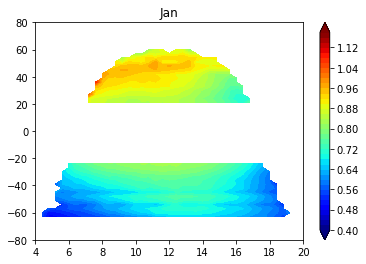

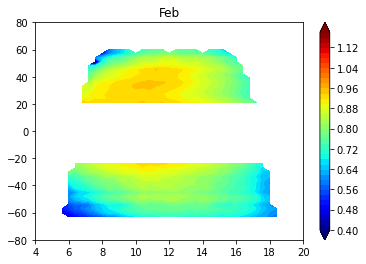

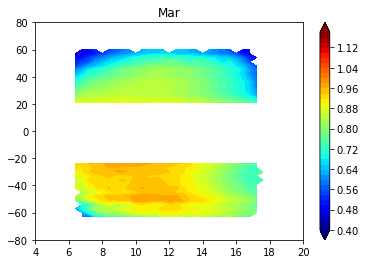

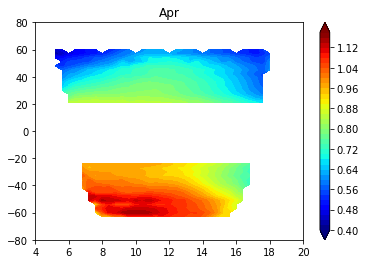

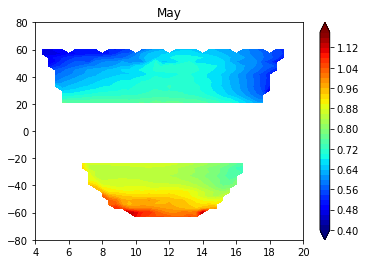

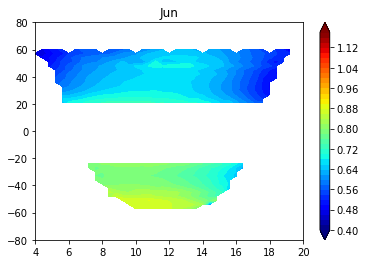

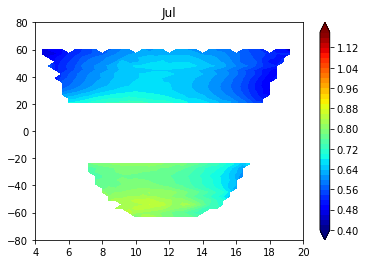

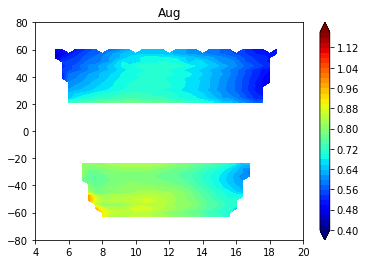

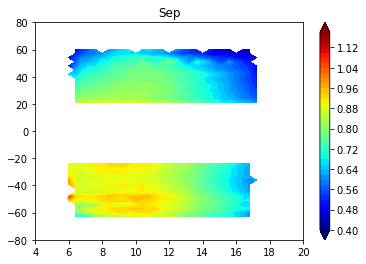

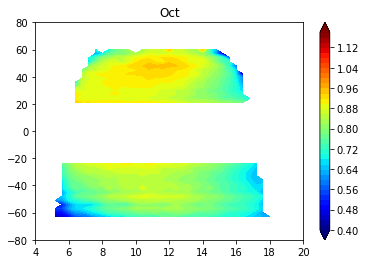

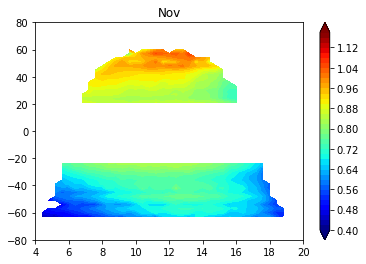

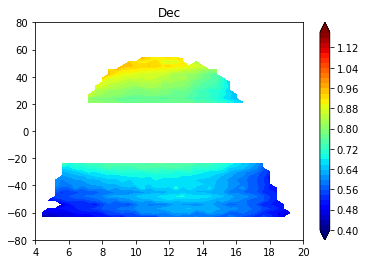

In [27]:
x = np.arange(0, 24, 0.4)
y = np.arange(-90, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)
levels=np.arange(0.4,1.2,0.02)
for i in range(12):
    fig, ax = plt.subplots()
    cs= ax.contourf(X,Y,np.transpose(on2_lt_month_ave[i,:,:]),levels=levels, cmap='jet', extend='both')
    cb=plt.colorbar(cs)
    plt.ylim([-80,80])
    plt.xlim([4,20])
    plt.title(month[i])
    # pyplot.savefig('/Users/wzihan/plot/gold/on2_month_mlt_'+str(i+1))

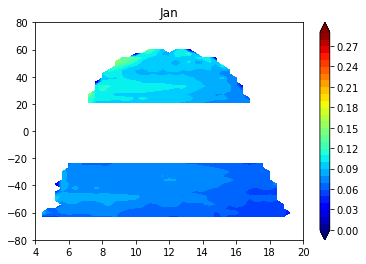

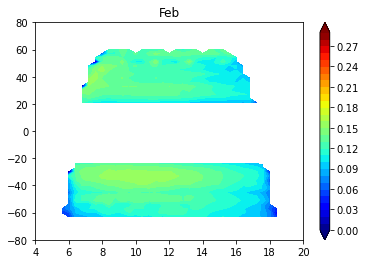

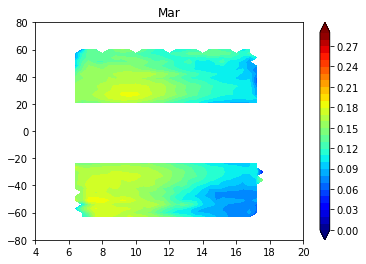

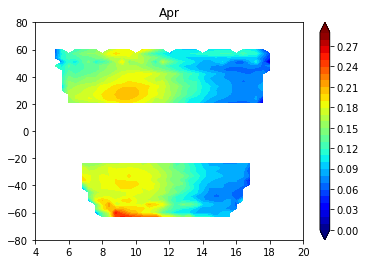

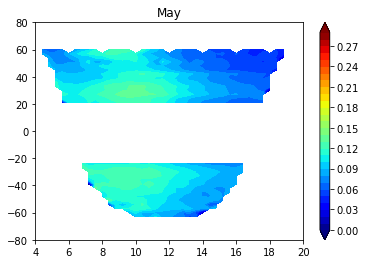

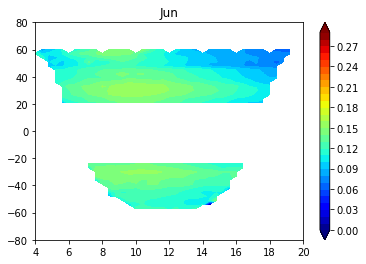

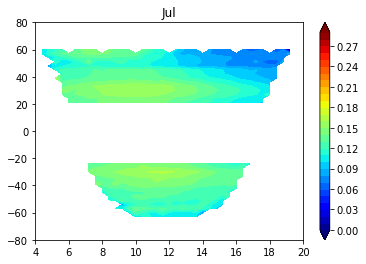

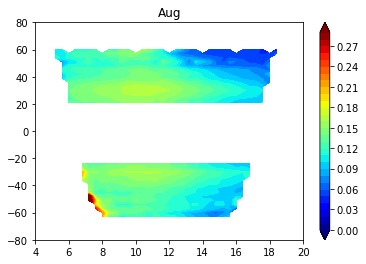

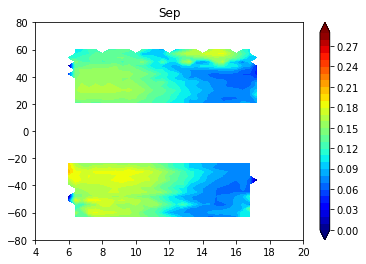

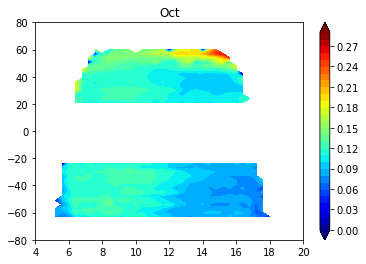

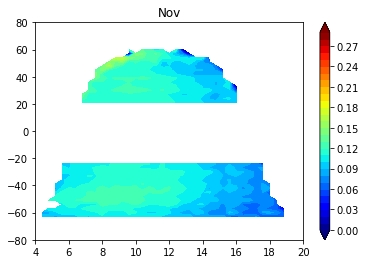

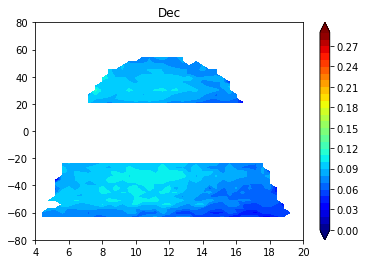

In [28]:
levels=np.arange(0,0.3,0.01)
for i in range(12):
    fig, ax = plt.subplots()
    cs= ax.contourf(X,Y,np.transpose(on2_lt_month_std[i,:,:]),levels=levels, cmap='jet', extend='both')
    cb=plt.colorbar(cs)
    plt.ylim([-80,80])
    plt.xlim([4,20])
    plt.title(month[i])
    # pyplot.savefig('/Users/wzihan/plot/gold/on2_month_mlt_'+str(i+1))

In [29]:
delta=np.zeros((12, nlat//2, nlt))

for i in range(12):
    for j in range(nlat//2):
        for k in range(nlt):
            s=on2_lt_month_ave[i,nlat-1-j,k]+on2_lt_month_ave[i,j,k]
            diff=on2_lt_month_ave[i,nlat-1-j,k]-on2_lt_month_ave[i,j,k]
            delta[i,nlat//2-1-j,k]=2*diff/s

In [30]:
x = np.arange(0, 24, 2/5.)
y = np.arange(0, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)

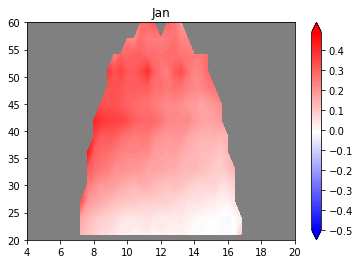

In [31]:
levels=np.arange(-0.5,0.5,0.01)
fig=plt.figure()
axs = fig.subplots(1, 1, sharex='col', sharey='row')

i=0
axs.set_facecolor("grey")  
cs= axs.contourf(X,Y,np.transpose(delta[i,:,:]),levels=levels, cmap='bwr', extend='both')
axs.set_ylim([20,60])
axs.set_xlim([4,20])
axs.set_title(month[i])
fig.colorbar(cs)

Text(0.5, 1.0, '$\\Delta$ $O/N_2$')

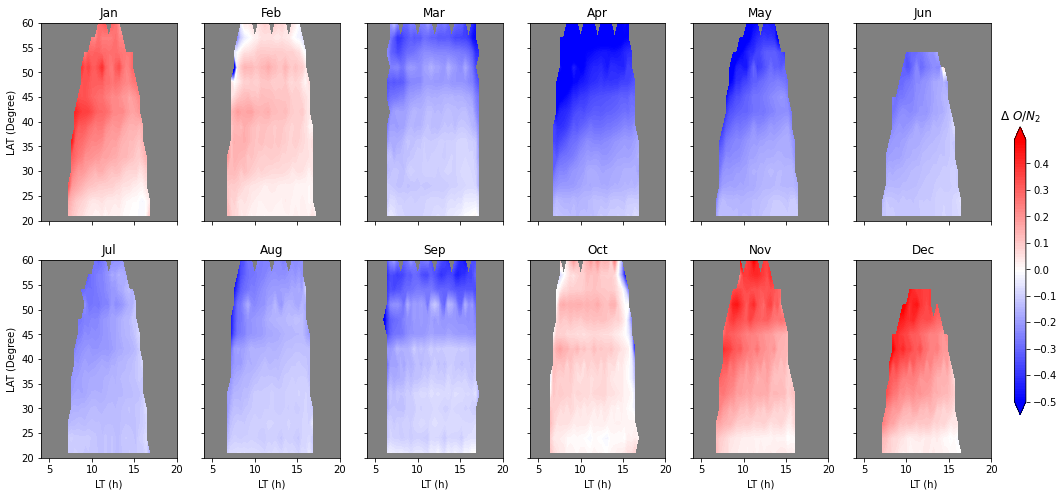

In [32]:
fig=plt.figure(figsize=(16,8))
axs = fig.subplots(2, 6, sharex='col', sharey='row')

for i in range(12):
    axs[i//6, i%6].set_facecolor("grey")  
    cs= axs[i//6, i%6].contourf(X,Y,np.transpose(delta[i,:,:]),levels=levels, cmap='bwr', extend='both')
    axs[i//6, i%6].set_ylim([20,60])
    axs[i//6, i%6].set_xlim([4,20])
    axs[i//6, i%6].set_title(month[i])
    if i//6==1:
        axs[i//6, i%6].set_xlabel('LT (h)')
    if i% 6 ==0:
        axs[i//6, i%6].set_ylabel('LAT (Degree)')
#     # pyplot.savefig('/Users/wzihan/plot/gold/on2_diff_month_mlt_'+str(i+1))
# plt.colorbar(cs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.5])
fig.colorbar(cs, cax=cbar_ax)
cbar_ax.set_title('$\Delta$ $O/N_2$')

([<matplotlib.axis.XTick at 0x7fcd906501c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

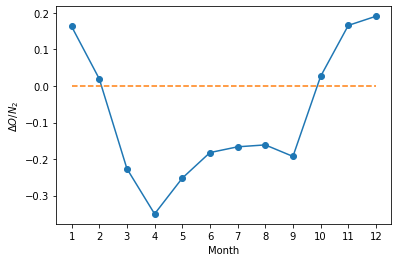

In [22]:
g=[]
for i in range(12):
    g.append(np.nanmean(delta[i,:,:]))
plt.plot(np.linspace(1,12,12), g, 'o-')
plt.plot([1,6,12], [0,0,0], '--')
plt.ylabel('$\Delta O/N_2$')
plt.xlabel('Month')
plt.xticks(np.linspace(1,12,12))

# Quiet time only (kp<3) and Long dependence

In [38]:
nlt=60
nlat=60
nlon=36
on2_lt_month=np.empty((12, nlt, nlat, nlon),dtype=object)
on2_lt_month_dt=np.empty((12, nlt, nlat, nlon),dtype=object)

for i in range(12):
    for j in range(nlat):
        for k in range(nlt):
            for l in range(nlon):
                on2_lt_month[i,j,k,l]=[]
                on2_lt_month_dt[i,j,k,l]=[]

In [39]:
for j in range(nlat):
    for k in range(nlt):
        for c in range(3):
            for d in range(2):
                l=on2_lt[3*j+c,2*k+d]
                for t in range(len(l)):
                    dtime=l[t][0]
                    doy=dtime.timetuple().tm_yday 
                    ind=(365*(dtime.year-2018)+doy-1)*8
                    kt=kptime[ind:ind+56]
                    kpindex=np.argmin(abs(dtime-kt))
                    lt=k*0.4
                    lon=(lt-dtime.hour-dtime.minute/60)*15
                    if lon>180: lon=lon-360
                    if lon<-180: lon=lon+360
                    if dtime.year in [2019,2020,2021] and kp[ind+kpindex]<3:
                        on2_lt_month[np.argmin(abs(dbin-doy)),j,k, int((lon+180)/10)].append(l[t][1])
                        on2_lt_month_dt[np.argmin(abs(dbin-doy)),j,k, int((lon+180)/10)].append(l[t][0])

In [40]:
on2_lt_month_ave=np.empty((12, nlt, nlat, nlon))
on2_lt_month_std=np.empty((12, nlt, nlat, nlon))
on2_lt_month_cnt=np.empty((12, nlt, nlat, nlon))
for i in range(12):
    for j in range(nlat):
        for k in range(nlt):
            for l in range(nlon):
                if len(on2_lt_month[i,j,k,l])==0:
                    on2_lt_month_ave[i,j,k,l]=np.nan
                    on2_lt_month_std[i,j,k,l]=np.nan
                    on2_lt_month_cnt[i,j,k,l]=0
                else:
                    on2_lt_month_ave[i,j,k,l]=np.mean(on2_lt_month[i,j,k,l])
                    on2_lt_month_std[i,j,k,l]=np.std(on2_lt_month[i,j,k,l])
                    on2_lt_month_cnt[i,j,k,l]=len(on2_lt_month[i,j,k,l])
                if j>22 and j<37:
                    on2_lt_month_ave[i,j,k,l]=np.nan
                    on2_lt_month_std[i,j,k,l]=np.nan
                    on2_lt_month_cnt[i,j,k,l]=0

In [41]:
for i in range(12):
    for j in range(nlat//2):
        for k in range(nlt):
            for l in range(nlon):
                if np.isnan(on2_lt_month_ave[i,nlat-1-j,k,l]) or np.isnan(on2_lt_month_ave[i,j,k,l]):
                    on2_lt_month_ave[i,nlat-1-j,k,l]=np.nan
                    on2_lt_month_ave[i,j,k,l]=np.nan

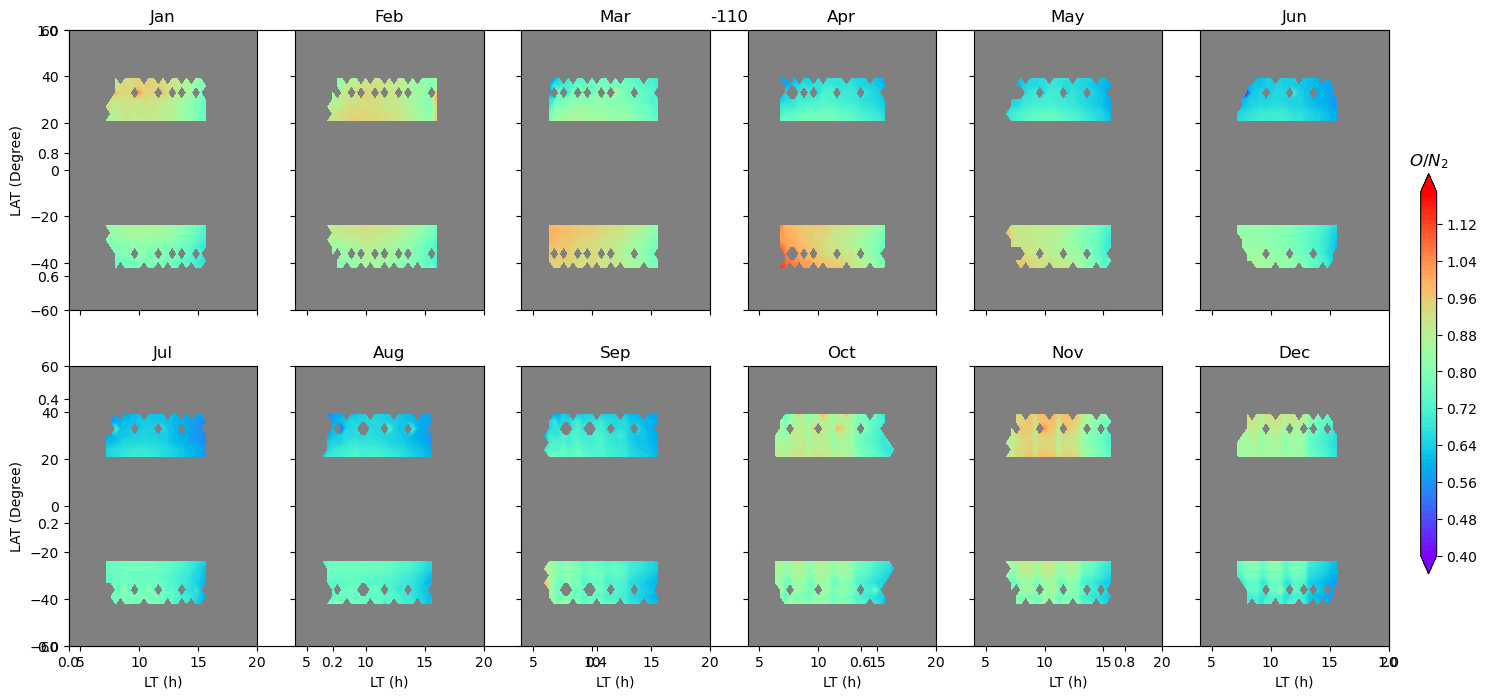

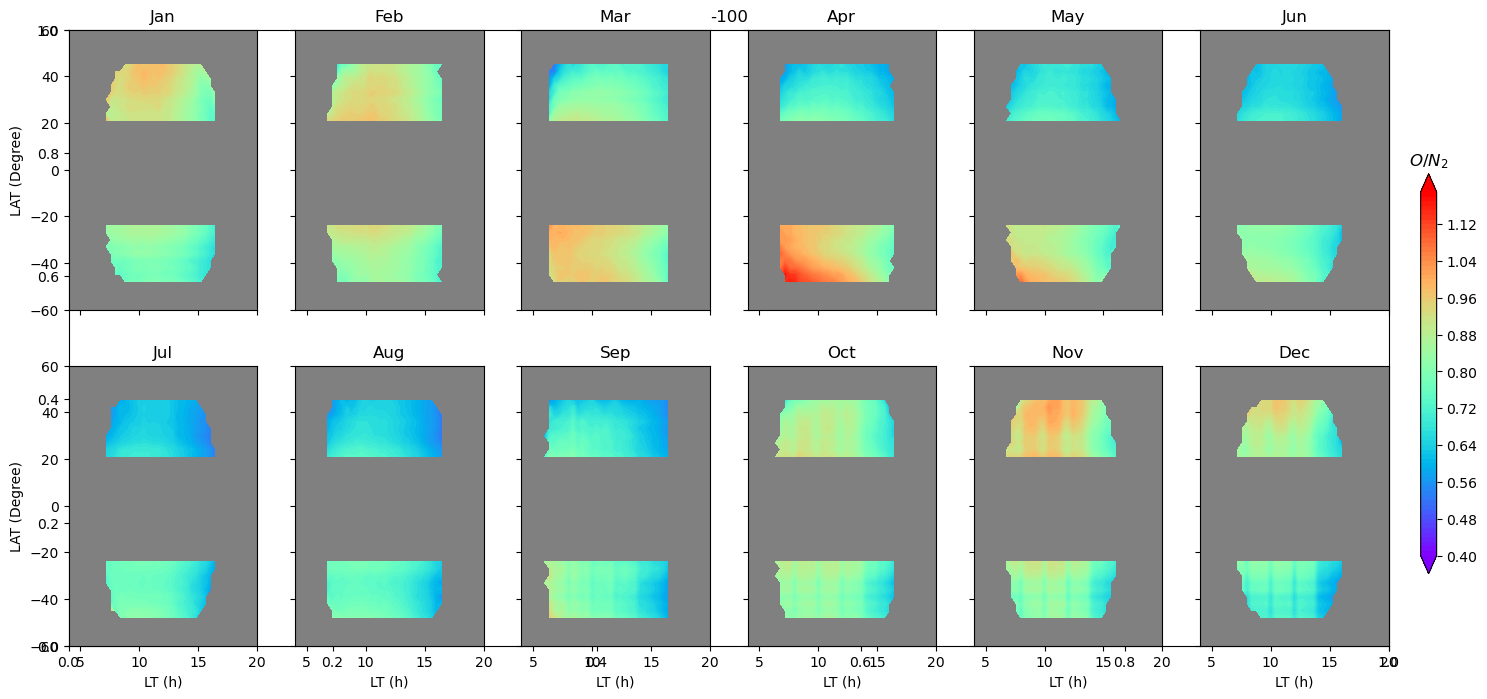

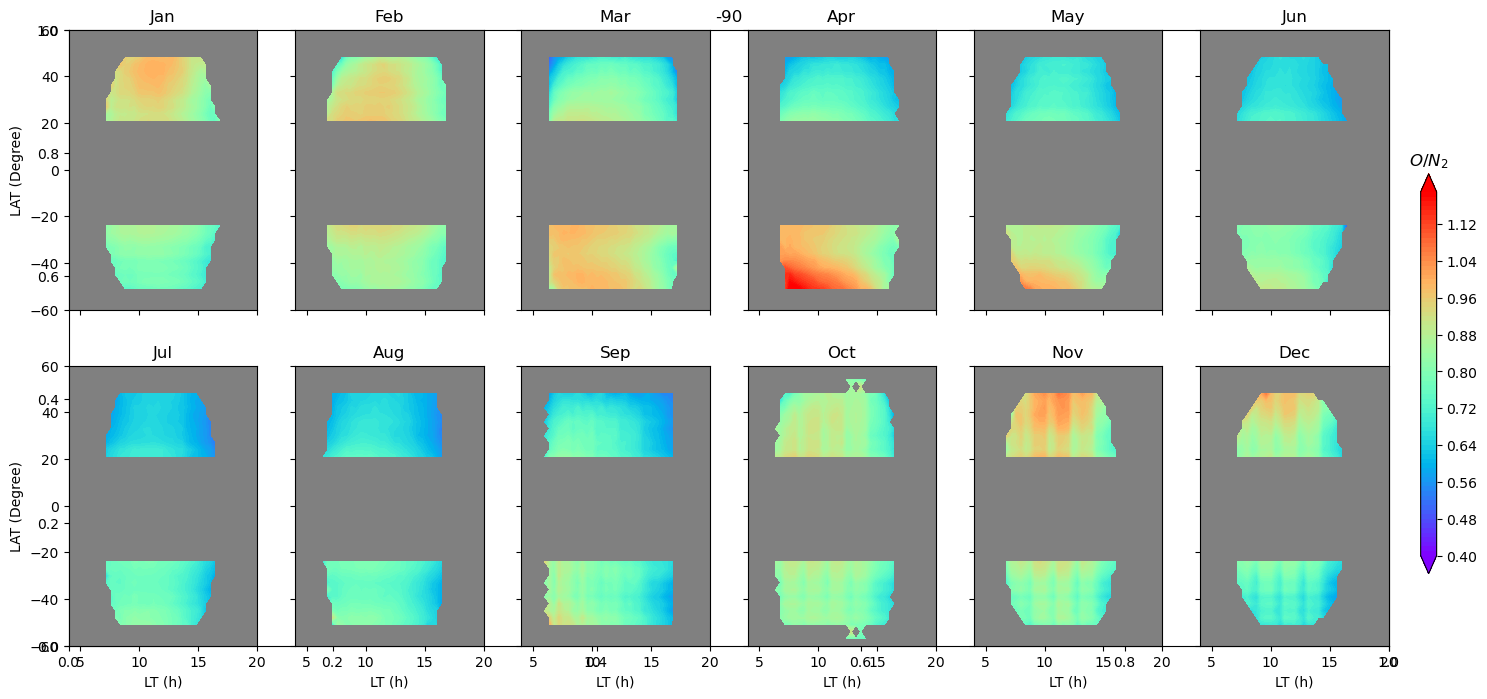

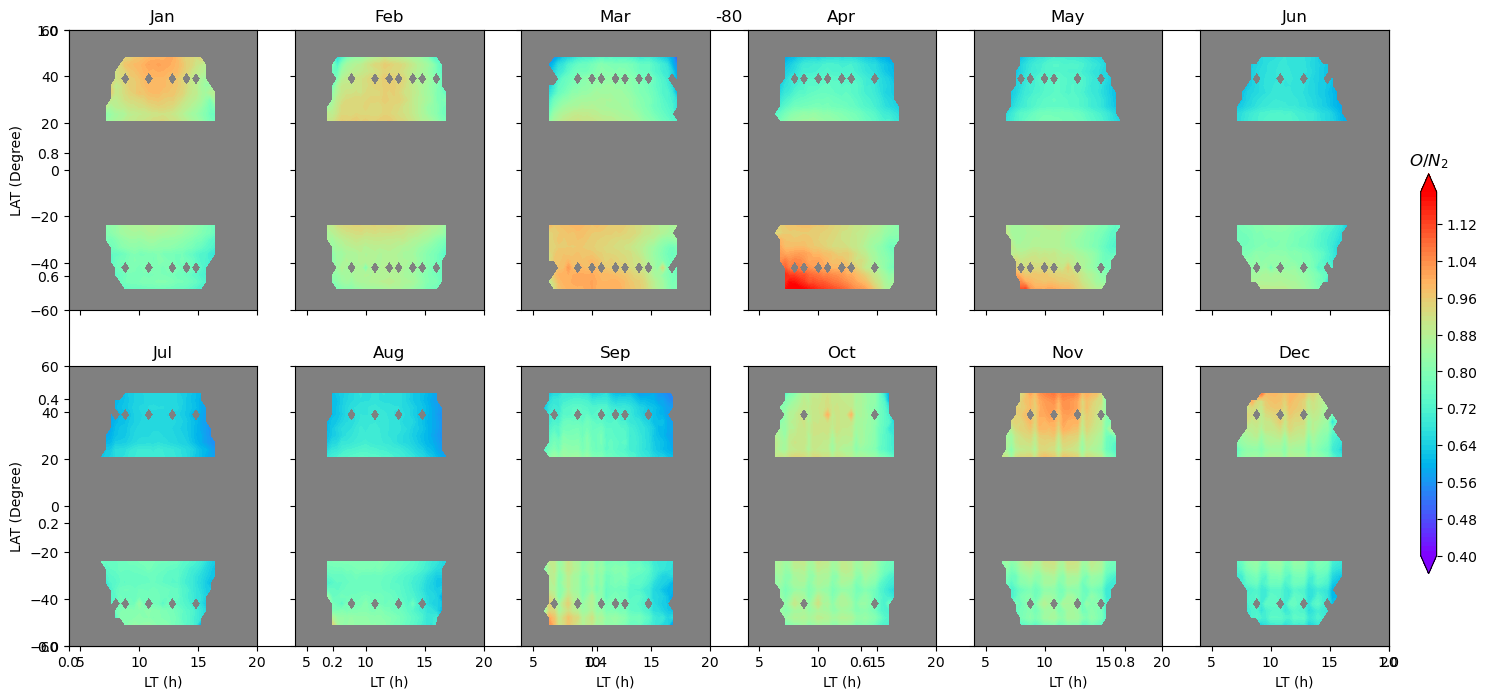

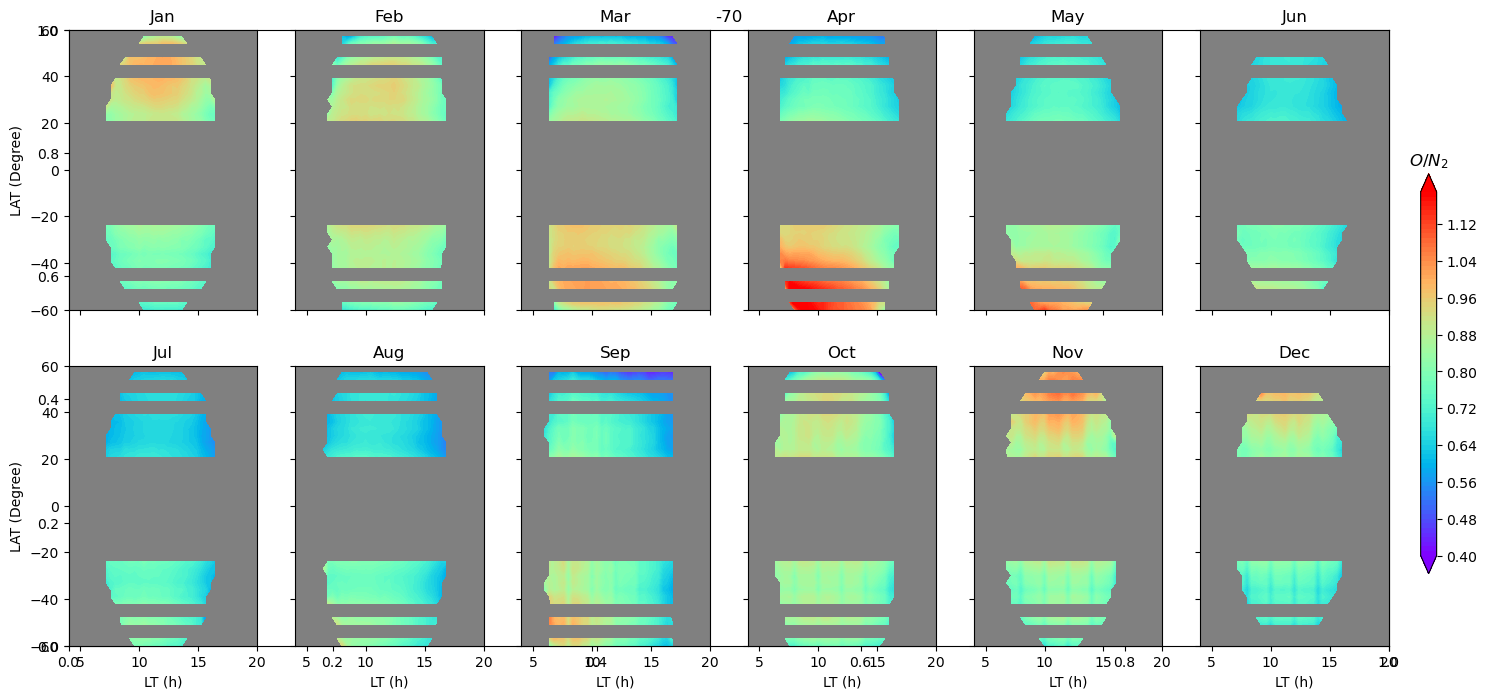

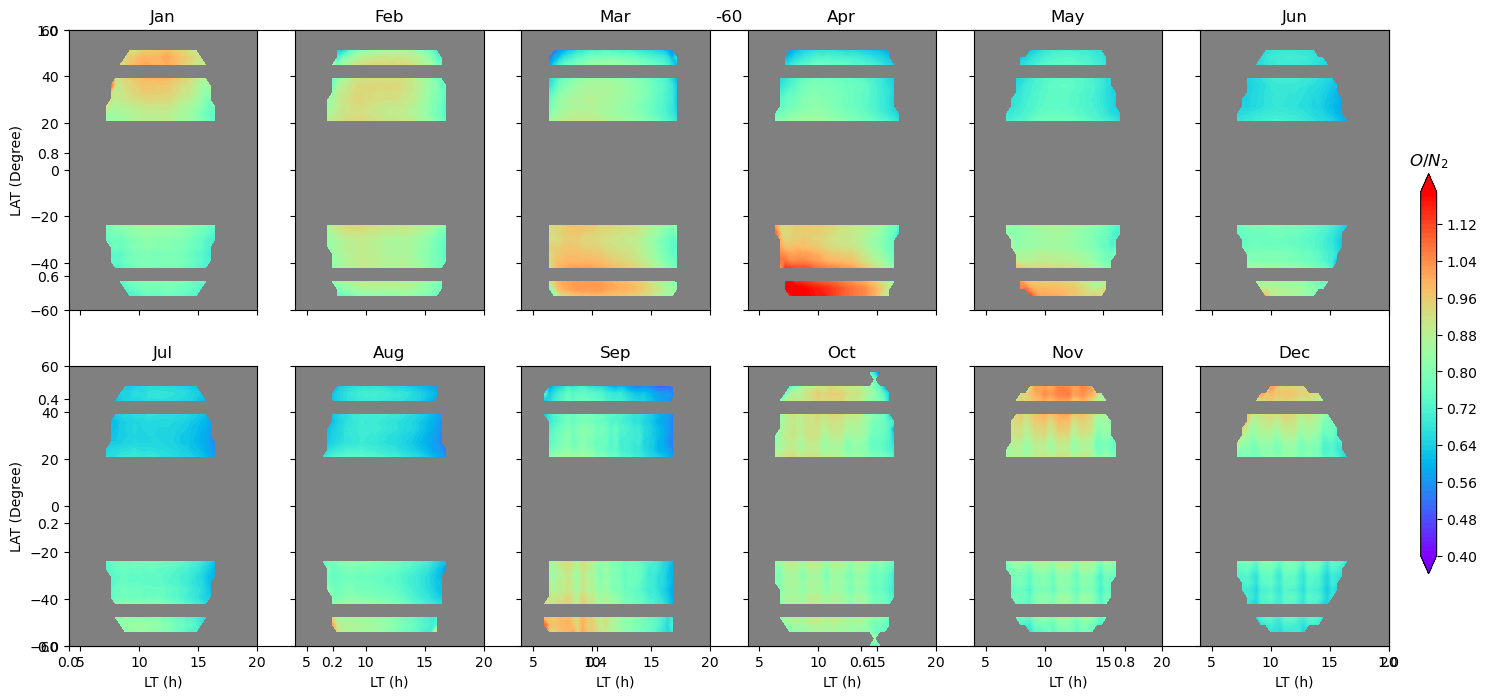

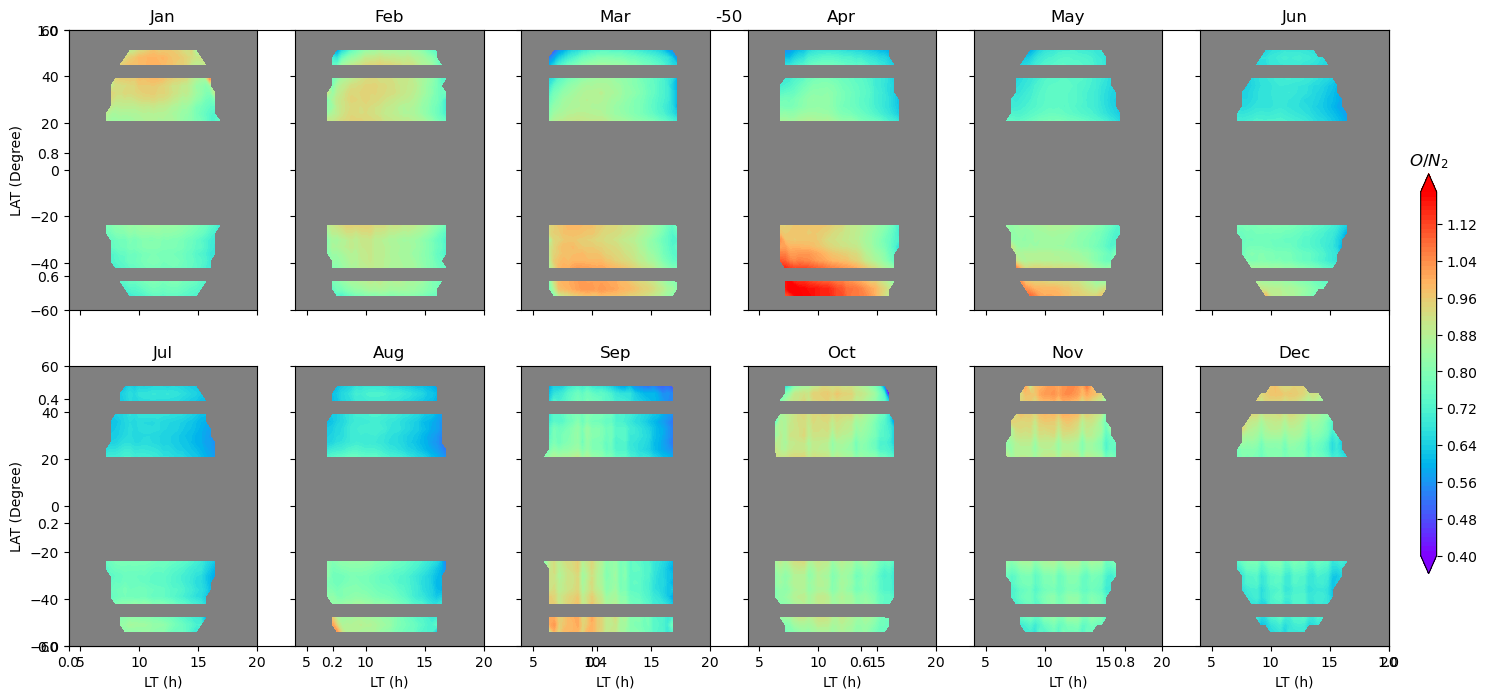

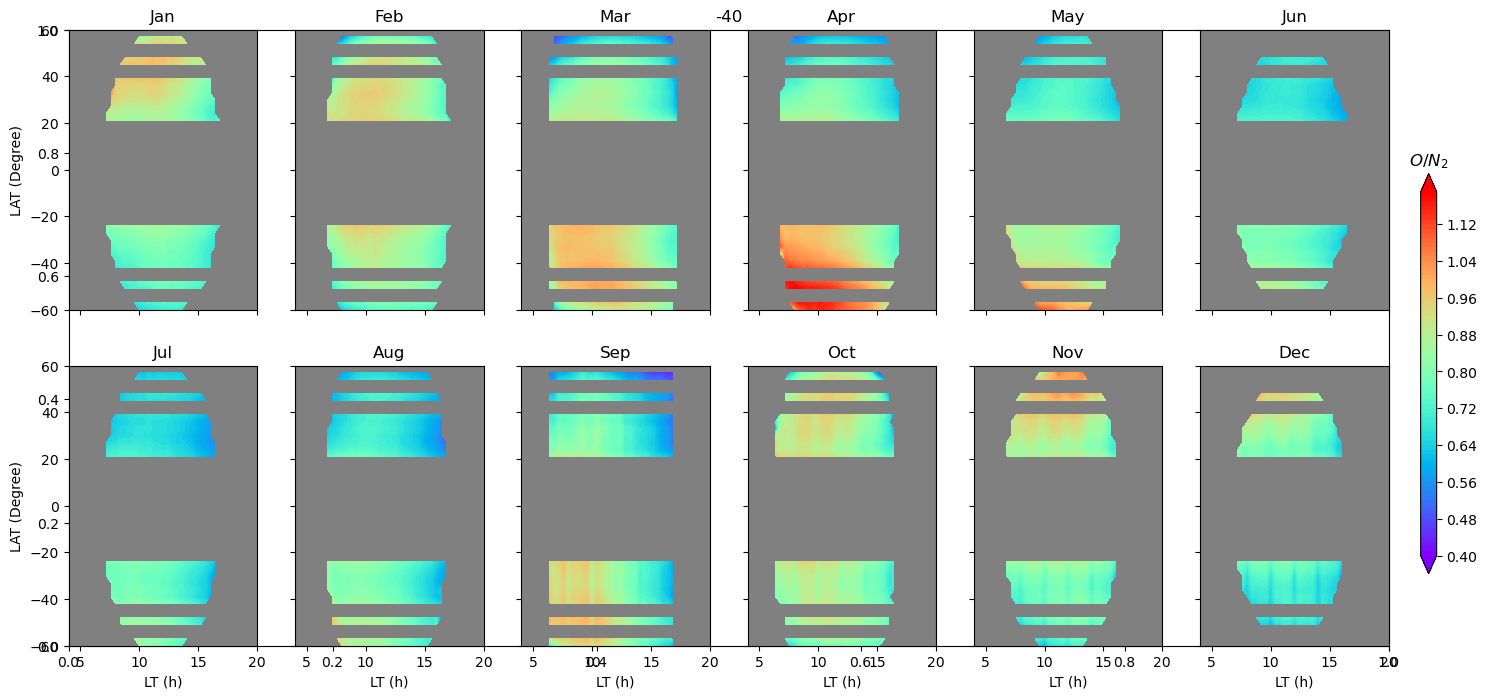

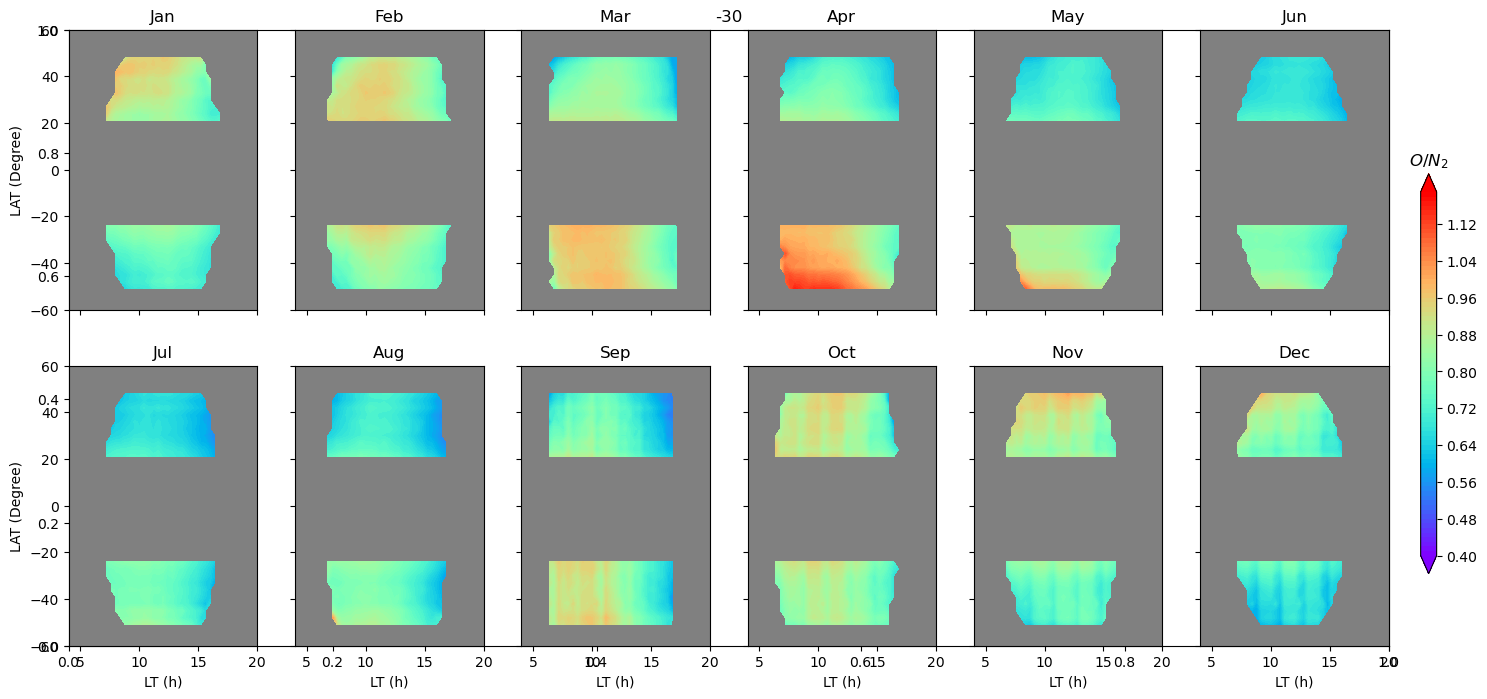

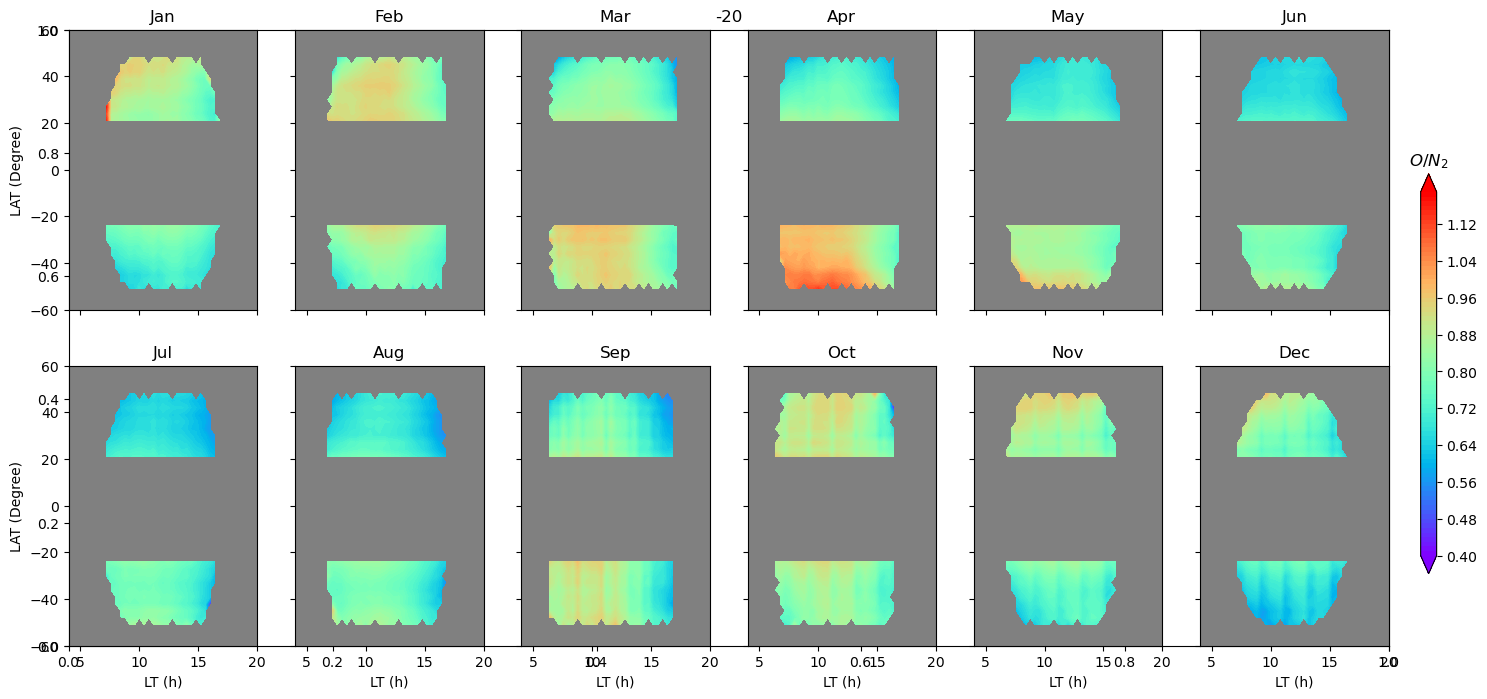

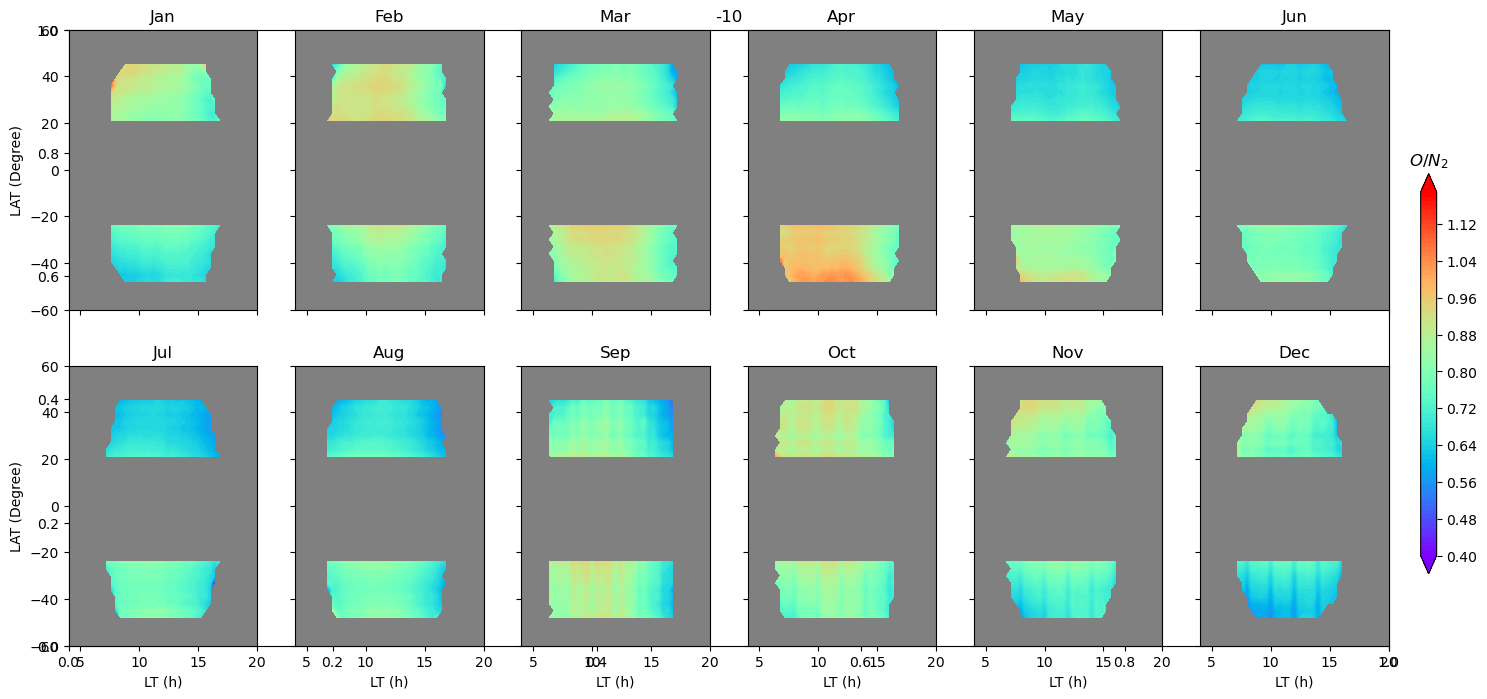

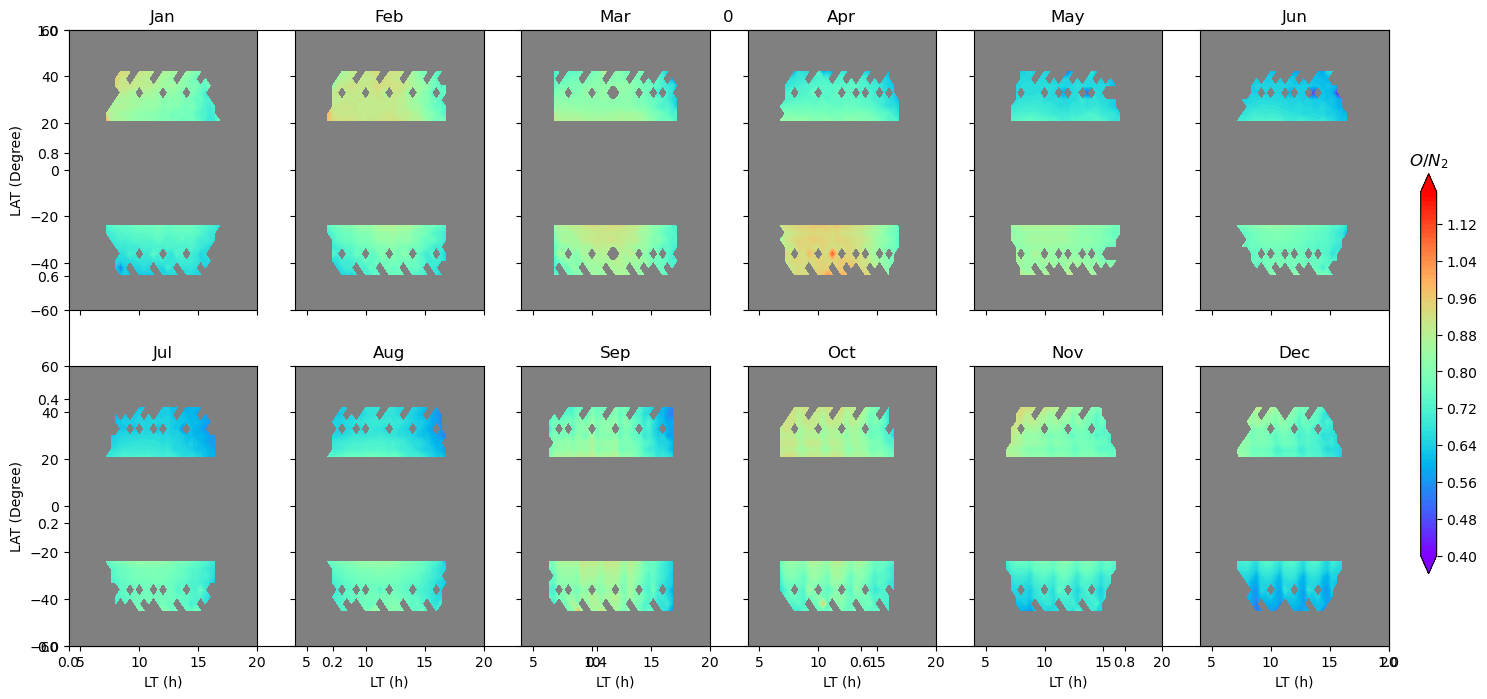

In [42]:
x = np.arange(0, 24, 0.4)
y = np.arange(-90, 90, 3)
X, Y = np.meshgrid(x, y)
levels=np.arange(0.4,1.2,0.01)
X=np.transpose(X)
Y=np.transpose(Y)
for l in range(7,19):
    fig=plt.figure(figsize=(16,8))
    plt.title(l*10-180)
    axs = fig.subplots(2, 6, sharex='col', sharey='row')
    for i in range(12):
        axs[i//6, i%6].set_facecolor("grey")  
        cs= axs[i//6, i%6].contourf(X,Y,np.transpose(on2_lt_month_ave[i,:,:,l]),levels=levels, cmap='rainbow', extend='both')
        axs[i//6, i%6].set_ylim([-60,60])
        axs[i//6, i%6].set_xlim([4,20])
        axs[i//6, i%6].set_title(month[i])
        if i//6==1:
            axs[i//6, i%6].set_xlabel('LT (h)')
        if i% 6 ==0:
            axs[i//6, i%6].set_ylabel('LAT (Degree)')
    #     # pyplot.savefig('/Users/wzihan/plot/gold/on2_diff_month_mlt_'+str(i+1))
    # plt.colorbar(cs)
    fig.subplots_adjust(right=0.95)
    cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.5])
    fig.colorbar(cs, cax=cbar_ax)
    cbar_ax.set_title('$O/N_2$')

Text(0.5, 1.0, '$\\Sigma O/N_2$')

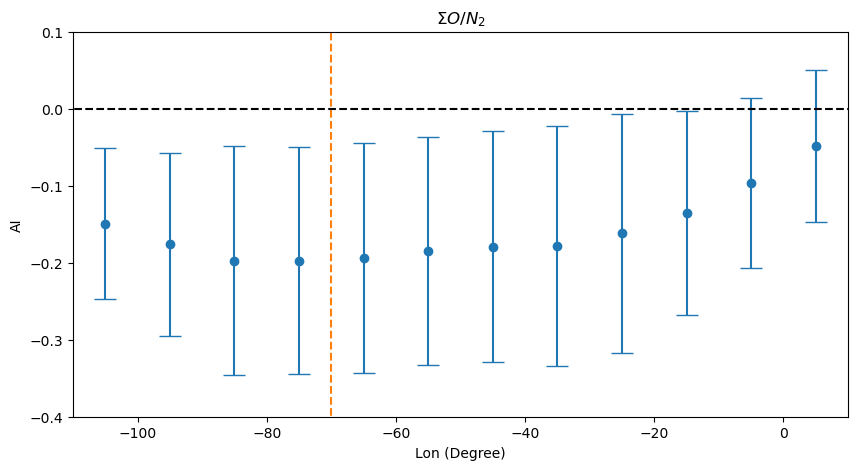

In [45]:
g=[]
e=[]
i=2
for l in range(7,19):
    s=np.nanmean(on2_lt_month_ave[i,:nlat//2,:,l])
    n=np.nanmean(on2_lt_month_ave[i,nlat//2:,:,l])
    g.append((n-s)/(n+s)*2)
    ds=np.nanstd(on2_lt_month_ave[i,:nlat//2,:,l])
    dn=np.nanstd(on2_lt_month_ave[i,nlat//2:,:,l])
    e.append((4/(n+s)**2)*(s**2*dn**2+n**2*ds**2)**0.5)

plt.figure(figsize=(10,5))
plt.errorbar(np.arange(-105,15,10), g, yerr=e, fmt='o', capsize=8)
plt.plot([-70,-70], [-1,0.1], '--')
plt.plot([-120,20], [0,0], 'k--')
plt.ylim([-0.4,0.1])
plt.xlim([-110,10])
plt.ylabel('AI')
plt.xlabel('Lon (Degree)')
plt.title('$\Sigma O/N_2$')
# plt.savefig('lon.svg')

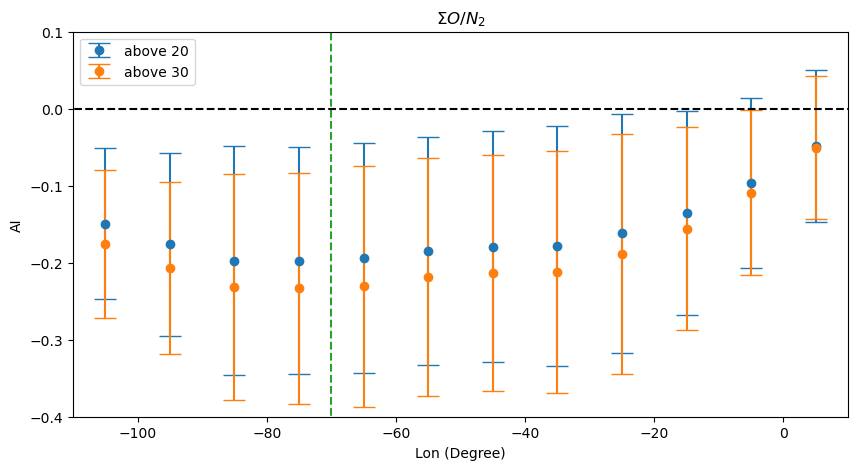

In [50]:
g=[]
e=[]
i=2
for l in range(7,19):
    s=np.nanmean(on2_lt_month_ave[i,:nlat//2,:,l])
    n=np.nanmean(on2_lt_month_ave[i,nlat//2:,:,l])
    g.append((n-s)/(n+s)*2)
    ds=np.nanstd(on2_lt_month_ave[i,:nlat//2,:,l])
    dn=np.nanstd(on2_lt_month_ave[i,nlat//2:,:,l])
    e.append((4/(n+s)**2)*(s**2*dn**2+n**2*ds**2)**0.5)

plt.figure(figsize=(10,5))
plt.errorbar(np.arange(-105,15,10), g, yerr=e, fmt='o', capsize=8, label='above 20')

g=[]
e=[]
i=2
for l in range(7,19):
    s=np.nanmean(on2_lt_month_ave[i,:nlat//2-10,:,l])
    n=np.nanmean(on2_lt_month_ave[i,nlat//2+10:,:,l])
    g.append((n-s)/(n+s)*2)
    ds=np.nanstd(on2_lt_month_ave[i,:nlat//2-10,:,l])
    dn=np.nanstd(on2_lt_month_ave[i,nlat//2+10:,:,l])
    e.append((4/(n+s)**2)*(s**2*dn**2+n**2*ds**2)**0.5)

plt.errorbar(np.arange(-105,15,10), g, yerr=e, fmt='o', capsize=8, label='above 30')
plt.plot([-70,-70], [-1,0.1], '--')
plt.plot([-120,20], [0,0], 'k--')
plt.ylim([-0.4,0.1])
plt.xlim([-110,10])
plt.ylabel('AI')
plt.xlabel('Lon (Degree)')
plt.title('$\Sigma O/N_2$')
plt.legend()
# plt.savefig('lon.svg')

# Daily O/N2 change

In [51]:
mlat=-30
mlt=12
mlat_index=(90+mlat)//3
mlt_index=mlt*15//3

In [52]:
def mag2geo_sphere_apex(mlat,mlt,h,t):
    
    # GEOPACK is based on a centered dipole coordinate.
    
    A = Apex(date=t)
    mlon = A.mlt2mlon(mlt, t)
    lat, lon = A.convert(mlat, mlon, 'apex', 'geo', height=0)
    return lat, lon

In [57]:
a = igrf.igrf('2018-01-01', glat=70, glon=-120, alt_km=100)

In [58]:
a

<xarray.Dataset>
Dimensions:  (alt_km: 1)
Coordinates:
  * alt_km   (alt_km) int64 100
Data variables:
    north    (alt_km) float64 5.474e+03
    east     (alt_km) float64 1.979e+03
    down     (alt_km) float64 5.526e+04
    total    (alt_km) float64 5.557e+04
    incl     (alt_km) float64 83.99
    decl     (alt_km) float64 19.88
Attributes:
    time:     2018-01-01
    isv:      0
    itype:    1
    glat:     70
    glon:     -120

In [ ]:
b=[[],[]]
inc=[[],[]]
dec=[[],[]]
for i in range(len(on2_mlt_month[0,mlat_index, mlt_index])):
    lat, lon = mag2geo_sphere_apex(mlat,mlt,0,on2_mlt_month_dt[0,mlat_index, mlt_index][i])
    mag=igrf.igrf(on2_mlt_month_dt[0,mlat_index, mlt_index][i], glat=lat, glon=lon, alt_km=150)
    b[0].append(mag.total.to_numpy()[0])
    inc[0].append(mag.incl.to_numpy()[0])
    dec[0].append(mag.decl.to_numpy()[0])
    
for i in range(len(on2_mlt_month[0,59-mlat_index, mlt_index])):
    lat, lon = mag2geo_sphere_apex(-mlat,mlt,0,on2_mlt_month_dt[0,59-mlat_index, mlt_index][i])
    mag=igrf.igrf(on2_mlt_month_dt[0,59-mlat_index, mlt_index][i], glat=lat, glon=lon, alt_km=150)
    b[1].append(mag.total.to_numpy()[0])
    inc[1].append(mag.incl.to_numpy()[0])
    dec[1].append(mag.decl.to_numpy()[0])

In [ ]:
plt.scatter(on2_mlt_month[0,mlat_index, mlt_index],b[0])
plt.scatter(on2_mlt_month[0,59-mlat_index, mlt_index],b[1])

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,mlat_index, mlt_index]).reshape(-1,1), np.array(b[0]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,59-mlat_index, mlt_index]).reshape(-1,1), np.array(b[1]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
plt.scatter(on2_mlt_month[0,mlat_index, mlt_index],inc[0])
plt.scatter(on2_mlt_month[0,59-mlat_index, mlt_index],inc[1])

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,mlat_index, mlt_index]).reshape(-1,1), np.array(inc[0]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,59-mlat_index, mlt_index]).reshape(-1,1), np.array(inc[1]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
plt.scatter(on2_mlt_month[0,mlat_index, mlt_index],dec[0])
plt.scatter(on2_mlt_month[0,59-mlat_index, mlt_index],dec[1])

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,mlat_index, mlt_index]).reshape(-1,1), np.array(dec[0]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,59-mlat_index, mlt_index]).reshape(-1,1), np.array(dec[1]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
sza=[[],[]]
for i in range(len(on2_mlt_month[0,mlat_index, mlt_index])):
    lat, lon = mag2geo_sphere_apex(mlat,mlt,0,on2_mlt_month_dt[0,mlat_index, mlt_index][i])
    sza[0].append(float(90)-get_altitude(lat, lon, on2_mlt_month_dt[0,mlat_index, mlt_index][i].replace(tzinfo=datetime.timezone.utc)))
    
for i in range(len(on2_mlt_month[0,59-mlat_index, mlt_index])):
    lat, lon = mag2geo_sphere_apex(-mlat,mlt,0,on2_mlt_month_dt[0,59-mlat_index, mlt_index][i])
    sza[1].append(float(90)-get_altitude(lat, lon, on2_mlt_month_dt[0,59-mlat_index, mlt_index][i].replace(tzinfo=datetime.timezone.utc)))

In [ ]:
plt.scatter(on2_mlt_month[0,mlat_index, mlt_index],sza[0])
plt.scatter(on2_mlt_month[0,59-mlat_index, mlt_index],sza[1])

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,mlat_index, mlt_index]).reshape(-1,1), np.array(sza[0]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,59-mlat_index, mlt_index]).reshape(-1,1), np.array(sza[1]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
doy=[[], []]
for i in range(len(on2_mlt_month[0,mlat_index, mlt_index])):
    dd=on2_mlt_month_dt[0,mlat_index, mlt_index][i]-datetime.datetime(2019,1,1)
    doy[0].append((dd.total_seconds()/86400)%365)
    
for i in range(len(on2_mlt_month[0,59-mlat_index, mlt_index])):
    dd=on2_mlt_month_dt[0,59-mlat_index, mlt_index][i]-datetime.datetime(2019,1,1)
    doy[1].append((dd.total_seconds()/86400)%365)

In [ ]:
plt.scatter(on2_mlt_month[0,mlat_index, mlt_index],doy[0])
plt.scatter(on2_mlt_month[0,59-mlat_index, mlt_index],doy[1])

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,mlat_index, mlt_index]).reshape(-1,1), np.array(doy[0]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,59-mlat_index, mlt_index]).reshape(-1,1), np.array(doy[1]).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
jh=io.readsav('W05HeatingVer3_2019.xdr')

In [ ]:
jh

In [ ]:
doy=jh['doyheating']
jhn=jh['heatingn']
jhs=jh['heatings']

In [ ]:
fn = interpolate.interp1d(doy, jhn)
fs = interpolate.interp1d(doy, jhs)

In [ ]:
jhn_s=np.mean(jhn.reshape(365,-1), axis=1)
jhs_s=np.mean(jhs.reshape(365,-1), axis=1)

In [ ]:
from scipy.signal import savgol_filter
djh=2*(jhn_s-jhs_s)/(jhn_s+jhs_s)
yhat = savgol_filter(djh, 61, 3)
plt.plot(djh)
print(np.where(abs(djh)<1e-2))
print(np.mean(djh), np.std(djh))

In [ ]:
jhng=[]
jhsg=[]
for i in range(len(on2_mlt_month[0,mlat_index, mlt_index])):
    dd=on2_mlt_month_dt[0,mlat_index, mlt_index][i]-datetime.datetime(2019,1,1)
    jhsg.append(fs(dd.total_seconds()/86400%365+1))

for i in range(len(on2_mlt_month[0,59-mlat_index, mlt_index])):
    dd=on2_mlt_month_dt[0,59-mlat_index, mlt_index][i]-datetime.datetime(2019,1,1)
    jhng.append(fn(dd.total_seconds()/86400%365+1))

In [ ]:
plt.scatter(on2_mlt_month[0,mlat_index, mlt_index],jhsg)
plt.scatter(on2_mlt_month[0,59-mlat_index, mlt_index],jhng)

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,mlat_index, mlt_index]).reshape(-1,1), np.array(jhsg).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

In [ ]:
z=np.concatenate((np.array(on2_mlt_month[0,59-mlat_index, mlt_index]).reshape(-1,1), np.array(jhng).reshape(-1,1)), axis=1)
cc =np.corrcoef(z, rowvar=False)[0,1]
cc

# Driver

In [ ]:
def mag_on2(mlat, mlt):
    mo=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    
    mlat_index=(90+mlat)//3
    mlt_index=mlt*15//3
    b_mlt_hn=np.empty((24),dtype=object)
    b_mlt_hs=np.empty((24),dtype=object)

    for i in range(24):
        lat, lon = mag2geo_sphere_apex(-mlat,mlt,0,datetime.datetime(2019,1,1,i,0,0))
        mag=igrf.igrf(datetime.datetime(2019,1,1,i,0,0), glat=lat, glon=lon, alt_km=150)
        b_mlt_hn[i]=mag
        lat, lon = mag2geo_sphere_apex(mlat,mlt,0,datetime.datetime(2019,1,1,i,0,0))
        mag=igrf.igrf(datetime.datetime(2019,1,1,i,0,0), glat=lat, glon=lon, alt_km=150)
        b_mlt_hs[i]=mag

    bn=np.array([b_mlt_hn[i].incl.to_numpy()[0] for i in range(24)])
    bs=np.array([-b_mlt_hs[i].incl.to_numpy()[0] for i in range(24)])

    deltab=2*(bn-bs)/(bn+bs)
    # plt.plot(deltab)

    plt.plot(deltab, label='Inclination')
    for m in range(12):
        s=on2_mlt_month[m,mlat_index,mlt_index]
        n=on2_mlt_month[m,59-mlat_index,mlt_index]
        sdt=on2_mlt_month_dt[m,mlat_index,mlt_index]
        ndt=on2_mlt_month_dt[m,59-mlat_index,mlt_index]

        on2_mlt_hn=np.empty((24),dtype=object)
        on2_mlt_hs=np.empty((24),dtype=object)
        b_mlt_hn=np.empty((24),dtype=object)
        b_mlt_hs=np.empty((24),dtype=object)

        for i in range(24):
            on2_mlt_hn[i]=[]
            on2_mlt_hs[i]=[]
            lat, lon = mag2geo_sphere_apex(-mlat,mlt,0,datetime.datetime(2019,1,1,i,0,0))
            mag=igrf.igrf(datetime.datetime(2019,1,1,i,0,0), glat=lat, glon=lon, alt_km=150)
            b_mlt_hn[i]=mag
            lat, lon = mag2geo_sphere_apex(mlat,mlt,0,datetime.datetime(2019,1,1,i,0,0))
            mag=igrf.igrf(datetime.datetime(2019,1,1,i,0,0), glat=lat, glon=lon, alt_km=150)
            b_mlt_hs[i]=mag

        for t in range(len(n)):
            dtime=ndt[t]
            h=dtime.hour
            on2_mlt_hn[h].append(n[t])

        for t in range(len(s)):
            dtime=sdt[t]
            h=dtime.hour
            on2_mlt_hs[h].append(s[t])

        on2_mlt_hn_ave=np.empty((24))
        on2_mlt_hn_std=np.empty((24))
        on2_mlt_hs_ave=np.empty((24))
        on2_mlt_hs_std=np.empty((24))

        for i in range(24):
            if len(on2_mlt_hn[i])==0:
                on2_mlt_hn_ave[i]=np.nan
                on2_mlt_hn_std[i]=np.nan
            else:
                on2_mlt_hn_ave[i]=np.mean(on2_mlt_hn[i])
                on2_mlt_hn_std[i]=np.std(on2_mlt_hn[i])

            if len(on2_mlt_hs[i])==0:
                on2_mlt_hs_ave[i]=np.nan
                on2_mlt_hs_std[i]=np.nan
            else:
                on2_mlt_hs_ave[i]=np.mean(on2_mlt_hs[i])
                on2_mlt_hs_std[i]=np.std(on2_mlt_hs[i])

    #     plt.errorbar(np.linspace(0,23,24), on2_mlt_hn_ave, yerr=on2_mlt_hn_std, fmt='o', capsize=3)
    #     plt.errorbar(np.linspace(0,23,24), on2_mlt_hs_ave, yerr=on2_mlt_hs_std, fmt='o', capsize=3)

        s=on2_mlt_hn_ave+on2_mlt_hs_ave
        diff=on2_mlt_hn_ave-on2_mlt_hs_ave
        delta=2*diff/s

        plt.plot(delta, label=mo[m], linestyle='dotted')
        plt.xlabel('UT')
        plt.ylabel('$\Delta$')
    plt.legend()

In [ ]:
mlat=-20
mlt=12
mag_on2(mlat, mlt)

In [ ]:
for mlt in range(6,18):
    for mlat in range(-60,0,10):
        mag_on2(mlat, mlt)

# UT

In [ ]:
on2_mlt_ut=np.empty((24, 60, 120),dtype=object)
on2_mlt_ut_dt=np.empty((24, 60, 120),dtype=object)

for i in range(24):
    for j in range(60):
        for k in range(120):
            on2_mlt_ut[i,j,k]=[]
            on2_mlt_ut_dt[i,j,k]=[]

In [ ]:
for j in range(60):
    for k in range(120):
        for c in range(3):
            l=on2_mlt[3*j+c,k]
            for t in range(len(l)):
                dtime=l[t][0]
                h=dtime.hour 
                on2_mlt_ut[h,j,k].append(l[t][1])
                on2_mlt_ut_dt[h,j,k].append(l[t][0])

In [ ]:
on2_mlt_ut_ave=np.empty((24, 60, 120))
on2_mlt_ut_std=np.empty((24, 60, 120))
on2_mlt_ut_cnt=np.empty((24, 60, 120))
for i in range(24):
    for j in range(60):
        for k in range(120):
            if len(on2_mlt_ut[i,j,k])==0:
                on2_mlt_ut_ave[i,j,k]=np.nan
                on2_mlt_ut_std[i,j,k]=np.nan
                on2_mlt_ut_cnt[i,j,k]=0
            else:
                on2_mlt_ut_ave[i,j,k]=np.mean(on2_mlt_ut[i,j,k])
                on2_mlt_ut_std[i,j,k]=np.std(on2_mlt_ut[i,j,k])
                on2_mlt_ut_cnt[i,j,k]=len(on2_mlt_ut[i,j,k])
            if j>22 and j<37:
                on2_mlt_ut_ave[i,j,k]=np.nan
                on2_mlt_ut_std[i,j,k]=np.nan
                on2_mlt_ut_cnt[i,j,k]=0

In [ ]:
delta=np.zeros((24, 30, 120))

for i in range(24):
    for j in range(30):
        for k in range(120):
            s=on2_mlt_ut_ave[i,59-j,k]+on2_mlt_ut_ave[i,j,k]
            diff=on2_mlt_ut_ave[i,59-j,k]-on2_mlt_ut_ave[i,j,k]
            delta[i,29-j,k]=2*diff/s

In [ ]:
x = np.arange(0, 24, 1/5.)
y = np.arange(0, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)

In [ ]:
levels=np.linspace(-0.5,0.5,101)
fig=plt.figure(figsize=(16,8))
axs = fig.subplots(3, 6, sharex='col', sharey='row')

for i in range(6,24,1):
    axs[i//6-1, i%6].set_facecolor("grey")  
    cs= axs[i//6-1, i%6].contourf(X,Y,np.transpose(delta[i,:,:]),levels=levels, cmap='bwr')
    axs[i//6-1, i%6].set_ylim([20,60])
    axs[i//6-1, i%6].set_title('UT='+str(i))
    if i//6==3:
        axs[i//6-1, i%6].set_xlabel('MLT (h)')
    if i% 6 ==0:
        axs[i//6-1, i%6].set_ylabel('MLAT (Degree)')
#     # pyplot.savefig('/Users/wzihan/plot/gold/on2_diff_month_mlt_'+str(i+1))
# plt.colorbar(cs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.2, 0.01, 0.5])
fig.colorbar(cs, cax=cbar_ax)
cbar_ax.set_title('$\Delta$ $O/N_2$')

In [ ]:
b_mlt_hn=np.empty((24, 20),dtype=object)
b_mlt_hs=np.empty((24, 20),dtype=object)
i=15
for mlt in range(24):
    for mlat in range(20):
        lat, lon = mag2geo_sphere_apex(-mlat*3,mlt,0,datetime.datetime(2019,1,1,i,0,0))
        mag=igrf.igrf(datetime.datetime(2019,1,1,i,0,0), glat=lat, glon=lon, alt_km=150)
        b_mlt_hn[mlt, mlat]=mag.incl.to_numpy()[0]
        lat, lon = mag2geo_sphere_apex(mlat*3,mlt,0,datetime.datetime(2019,1,1,i,0,0))
        mag=igrf.igrf(datetime.datetime(2019,1,1,i,0,0), glat=lat, glon=lon, alt_km=150)
        b_mlt_hs[mlt, mlat]=mag.incl.to_numpy()[0]

In [ ]:
b_mlt_hn=-b_mlt_hn
deltab=2*(b_mlt_hn-b_mlt_hs)/(b_mlt_hn+b_mlt_hs)

In [ ]:
x = np.arange(0, 24, 1)
y = np.arange(0, 60, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)
plt.contourf(X,Y,deltab, cmap='bwr', levels=np.linspace(-0.5, 0.5, 101))
plt.colorbar()

In [ ]:
x = np.arange(0, 24, 1/5.)
y = np.arange(0, 90, 3)
X, Y = np.meshgrid(x, y)
X=np.transpose(X)
Y=np.transpose(Y)
plt.contourf(X,Y,np.transpose(delta[15,:,:]),levels=levels, cmap='bwr')